# **Hindi Hatespeech Detection**

---
Hate speech detection is a critical task in natural language processing, particularly in the context of social media platforms where hateful content can have significant real-world consequences. In this notebook, we focus on the detection of hate speech in Hindi text using machine learning techniques.

We will classify the sentences on two labels Needs_moderation and Non-hostile.


In [1]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 6.3 MB/s eta 0:00:00


In [2]:
!pip install scikit-learn

In [3]:
import pandas as pd
import emoji
import re
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier # Works well
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier # Works well
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC # Works well
from sklearn.tree import DecisionTreeClassifier # Works well
from sklearn.neighbors import KNeighborsClassifier # Works well
from sklearn.naive_bayes import MultinomialNB # Meh
from sklearn.metrics import classification_report
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

# Download necessary resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
data = pd.read_csv('/content/constraint_Hindi_Train - Sheet1.csv')
data.head()

,Unique ID,Post,Labels Set
0,1,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,"hate,offensive"
1,2,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,non-hostile
2,3,"सुशांत ने जो बिजनेस डील 9 जून को की थी, वो डील...",non-hostile
3,4,@prabhav218 साले जेएनयू छाप कमिने लोग हिन्दुओं...,"defamation,offensive"
4,5,#unlock4guidelines - अनलॉक-4 के लिए गाइडलाइन्स...,non-hostile


In [5]:
data['Labels Set'] = data['Labels Set'].replace({'offensive': 'hate', 'defamation': 'hate'})

# Verify the changes
data['Labels Set'].value_counts()

Labels Set
non-hostile                       3050
hate                              1188
fake                              1009
hate,offensive                     163
defamation,offensive                81
defamation,hate                     74
defamation,fake                     34
defamation,hate,offensive           28
fake,offensive                      28
fake,hate                           27
defamation,fake,offensive           24
defamation,fake,hate                 9
defamation,fake,hate,offensive       9
fake,hate,offensive                  4
Name: count, dtype: int64

In [6]:
data['Labels Set'] = data['Labels Set'].replace({'offensive': 'hate', 'defamation': 'hate', 'hate,offensive': 'hate', 'defamation,offensive': 'hate', 'defamation,hate': 'hate', 'defamation,fake': 'hate', 'defamation,hate,offensive': 'hate', 'fake,offensive': 'hate', 'fake,hate': 'hate', 'defamation,fake,offensive': 'hate', 'defamation,fake,hate': 'hate', 'defamation,fake,hate,offensive': 'hate', 'fake,hate,offensive': 'hate'})
print(data['Labels Set'].value_counts())

Labels Set
non-hostile    3050
hate           1669
fake           1009
Name: count, dtype: int64


In [7]:
data['Labels Set'] = data['Labels Set'].replace({'hate': 'needs_moderation', 'fake': 'needs_moderation'})
print(data['Labels Set'].value_counts())

Labels Set
non-hostile         3050
needs_moderation    2678
Name: count, dtype: int64


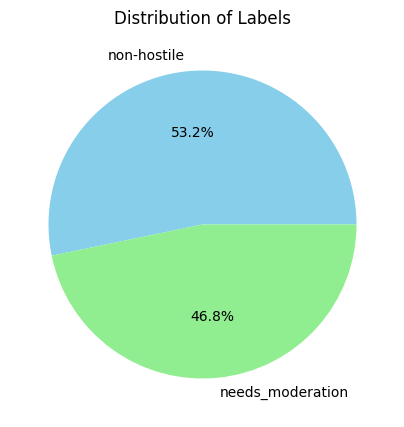

In [8]:
# Count the number of occurrences for each label
label_counts = data['Labels Set'].value_counts()

# Plot a pie chart
plt.figure(figsize=(5, 5))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightgreen'])
plt.title('Distribution of Labels')
plt.show()

Stopwords are common words like "इसका", "करते", and "मगर" that occur frequently in a language but often do not carry significant meaning in the context of text analysis. We remove them because they can add noise to our analysis and don't provide useful information for tasks like classification or sentiment analysis.

In [9]:
STOPWORDS = ["अंदर","अत","अदि","अप","अपना","अपनि","अपनी","अपने","अभि","अभी","आदि","आप","इंहिं","इंहें","इंहों","इतयादि","इत्यादि","इन","इनका","इन्हीं","इन्हें","इन्हों","इस","इसका","इसकि","इसकी","इसके","इसमें","इसि","इसी","इसे","उंहिं","उंहें","उंहों","उन","उनका","उनकि","उनकी","उनके","उनको","उन्हीं","उन्हें","उन्हों","उस","उसके",'थी,',"उसि","उसी","उसे","एक","एवं","एस","एसे","ऐसे","ओर","और","कइ","कई","कर","करता","करते","करना","करने","करें","कहते","कहा",'कहाँ',"का","काफि","काफ़ी","कि","किंहें","किंहों","कितना","किन्हें","किन्हों","किया","किर",'हम',"किस","किसि","किसी","किसे","की","कुछ","कुल","के","को","कोइ","कोई","कोन","कोनसा","कौन","कौनसा","गया","घर","जब","जहाँ","जहां","जा","जिंहें","जिंहों","जितना","जिधर","जिन","जिन्हें","जिन्हों","जिस","जिसे","जीधर","जेसा","जेसे","जैसा","जैसे","जो","तक","तब","तरह","तिंहें","तिंहों","तिन","तिन्हें","तिन्हों","तिस","तिसे","तो","था","थि","थी","थे","दबारा","दवारा","दिया","दुसरा","दुसरे","दूसरे","दो","द्वारा","न","नहिं","नहीं","ना","निचे","निहायत","नीचे","ने","पर","पहले","पुरा","पूरा","पे","फिर","बनि","बनी","बहि","बही","बहुत","बाद","बाला","बिलकुल","भि","भितर","भी","भीतर","मगर","मानो","मे","में","यदि","यह","यहाँ","यहां","यहि",'सैन्\u200dय','सम्\u200dमान', 'नई', 'दिल्\u200dली', 'संस्\u200dकार।',"यही","या","यिह","ये","रखें","रवासा","रहा","रहे","ऱ्वासा","लिए","लिये","लेकिन","व","वगेरह","वरग","वर्ग","वह","वहाँ","वहां","वहिं","वहीं","वाले","वुह","वे","वग़ैरह","संग","सकता","सकते","सबसे","सभि",'श्री','स्\u200dटीफन','माध्\u200dयम',"सभी","साथ","साबुत","साभ","सारा","से","सो","हि","ही","हुअ","हुआ","हुइ","हुई","हुए","हे","हें","है","हैं","हो","होता","होति","होती","होते","होना","होने"'थी,', 'वो','आ','हैं.', 'नए', 'हैं,','जाएगी', 'है।','है', 'क्यों','है,']

In [10]:
# Function to remove stopwords
def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in STOPWORDS]
    return ' '.join(filtered_tokens)

In [11]:
# Function to remove URLs
def remove_urls(text):
    return re.sub(r'http\S+', '', text)

In [12]:
# Function to remove emojis
def remove_emojis(text):
    return emoji.demojize(text)

In [13]:
def remove_hindi_punctuation(text):
    # Define a regular expression pattern to match Hindi punctuation characters
    hindi_punctuation_pattern = r'[^\w\s\d\u0900-\u097F]'
    # Substitute Hindi punctuation characters with an empty string
    clean_text = re.sub(hindi_punctuation_pattern, '', text)
    return clean_text

In [14]:
# Preprocess the text data
data['Post'] = data['Post'].apply(remove_urls)  # Remove URLs
data['Post'] = data['Post'].apply(remove_emojis)  # Remove emojis
data['Post'] = data['Post'].apply(remove_stopwords)  # Remove stopwords

data['Post'] = data['Post'].apply(remove_hindi_punctuation)

In [15]:
#Preprocss
'''
data['Post'] = data['Post'].apply(lambda x: x.lower())
data['Post'] = data['Post'].str.replace('[^a-zA-Z\s]', '', regex=True)
'''

"\ndata['Post'] = data['Post'].apply(lambda x: x.lower())\ndata['Post'] = data['Post'].str.replace('[^a-zA-Z\\s]', '', regex=True)\n"

**DO NOT READ ALL THESE YOU MIGHT LOSE YOUR SANITY**

In [16]:
bad_words = ['मृत', 'दुर्भाग्यशाली', 'अभागा', 'बदनसीब', 'भाग्यहीन', 'मनहूस', 'बदकिस्मत', 'मंदभाग्य', 'बदक़िस्मत', 'दईमारा', 'कमबख्त','कमबख़्त', 'अधन्य', 'अभागी', 'आवासहीन', 'आश्रयहीन', 'गृहहीन', 'गृहविहीन', 'बेघर', 'बेघरबार', 'अगतिक', 'अगेह', 'अनिकेत', 'बदबूदार','दुर्गंधपूर्ण', 'दुर्गंधयुक्त', 'दुर्गंधित', 'ढीला', 'अश्लिष्ट', 'असंयुक्त', 'असंयोजित', 'असंबद्ध', 'अलग', 'अजुड़ा', 'अजोड़', 'पृथक्', 'जुदा', 'पृथक', 'अपृक्त', 'पराधीन', 'गुलाम', 'परतंत्र', 'अन्याधीन', 'अपरवश', 'परवश', 'अवश', 'अबस', 'ढीला', 'जड़', 'अचैतन्य', 'जड़त्वयुक्त', 'स्थूल', 'अजैव', 'भौतिक', 'अचेतन', 'चेतनारहित', 'अजीव', 'अनात्म', 'आत्मारहित', 'अफल', 'अफलित', 'फलहीन', 'फलरहित', 'फलविहीन', 'निस्संतान', 'निःसंतान', 'बेऔलाद', 'संतानहीन', 'संतानरहित', 'अऊत', 'अनपत्य', 'भली-भाँति', 'भली_भाँति', 'भरपूर', 'भलीभाँति', 'भली-भांति', 'भली_भांति', 'भलीभांति', 'पंखहीन', 'पक्षरहित', 'अपक्ष', 'अपच्छी', 'अपत्र', 'अतकनीकी', 'ग़ैरतकनीकी', 'गैरतकनीकी', 'तकनीकहीन', 'प्राविधिहीन', 'दुर्गुणी', 'अगुणी', 'अपगुणी', 'ऐबी', 'खोटा', 'विपरीत', 'प्रतिकूल', 'खिलाफ', 'ख़िलाफ़', 'विरुद्ध', 'प्रतीप', 'कुस्वभावी', 'कुबुद्धि', 'दुश्शील', 'बदमिज़ाज', 'बदमिजाज', 'निकम्मा', 'निठल्ला', 'अकर्मण्य', 'निखट्टू', 'अनेरा', 'बेकार', 'फालतू', 'गायताल', 'अकर्मा', 'नालायक', 'ना-लायक', 'अनलायक', 'बेकदर', 'बेक़दर', 'बेक़द्र', 'बेकद्र', 'कठोरहृदय', 'कठोर_हृदय', 'पत्थरदिल', 'संगदिल', 'पाषाण_हृदय', 'हानिकारक', 'क्षतिकारी', 'हानिकर', 'नुक़सानदेह', 'नुकसानदेह', 'हानिप्रद', 'अनर्थकारी', 'क्षतिकर', 'अपमानजनक', 'गूदेदार', 'अप्रसन्नतापूर्वक', 'नाराज़गीपूर्वक', 'नाख़ुशी_से', 'नाराजगीपूर्वक', 'नाखुशी_से', 'पास_में', 'नज़दीक', 'नजदीक', 'निकट_में', 'क़रीब_में', 'समीप', 'निकट', 'पास', 'क़रीब', 'करीब', 'सन्निकट', 'खपड़ा', 'खपरा', 'खपड़ैल', 'खपरैल', 'खप्पर', 'खप्पड़', 'टाइल', 'टॉइल', 'संघर्ष', 'जंग', 'लड़ाई', 'द्वंद्व', 'द्वन्द्व', 'उन्मुक्त', 'आज़ाद', 'आजाद', 'खुला', 'बंधनमुक्त', 'मुक्त', 'अजाद', 'अनिबद्ध', 'मुंच', 'बन्धनमुक्त', 'अबद्ध', 'वीत', 'खीज', 'झुँझलाहट', 'कुढ़न', 'भँड़ास', 'खुंदक', 'खीस', 'अनख', 'भय', 'खौफ', 'ख़ौफ़', 'डर', 'त्रास', 'भीति', 'संत्रास', 'अपभय', 'दहशत', 'खीजना', 'झुँझलाना', 'खिजलाना', 'खिजना', 'कुढ़ना', 'खलना', 'बुरा_लगना', 'अखरना', 'विलाप_करना', 'कलपना', 'बिलखना', 'सोचना', 'दुखी_होना', 'सोंचना', 'अनमनाना', 'उदास_होना', 'अनमनाना', 'चिंताजनक', 'गंभीर', 'चिंतनीय', 'नाजुक', 'शोचनीय', 'सोचनीय', 'नाज़ुक', 'लँगड़ाना', 'लँगड़ाहट', 'लँगड़ापन', 'भचक', 'रुंडित', 'रुण्डित', 'अकारण', 'बेमतलब', 'निष्कारण', 'कारणहीनतः', 'अनिमित्त', 'बिगाड़ना', 'खराब_करना', 'उड़ना', 'गायब_होना', 'छू-मंतर_होना', 'उड़न-छू_होना', 'छूमंतर_होना', 'उड़नछू_होना', 'रौंद', 'रौंदाई', 'हँसी-मज़ाक़', 'हँसी-मजाक', 'हँसी_मज़ाक़', 'हँसी_मजाक', 'खिलवाड़', 'खेलवाड़', 'दिल्लगी', 'ठिठोली', 'ठट्ठा', 'हास्य-परिहास', 'हास-परिहास', 'विनोद', 'कौतुक', 'हँसी', 'परिहास', 'चुहल', 'प्रहसन', 'मज़ाक', 'मजाक', 'हास्य', 'विनोदोक्ति', 'अभिहास', 'धमा-चौकड़ी', 'धमाचौकड़ी', 'उछल-कूद', 'उछलकूद', 'कूद-फाँद', 'कूदफाँद', 'फुसफुसाहट', 'फुसफुस', 'फुस-फुस', 'खुसुफुसाहट', 'खुसुरफुसुर', 'खुसफुसाहट', 'खुसरफुसर', 'खुसर-फुसर', 'खुसुर-फुसुर', 'खुसखुस', 'खुस-खुस', 'खुसपुस', 'खुस_-फुस', 'तेजाबी', 'तेज़ाबी', 'तलछटी', 'अवसादी', 'तलोंछी', 'तलौछी', 'नकलची', 'नक़लची', 'अनुकारी', 'अनुहारक', 'अनुहारी', 'नीचा', 'निम्न', 'अतुंग', 'निभृत', 'अनुच्च', 'अनुन्नत्त', 'अनुन्नत', 'अनूर्ध्व', 'अरक्तक', 'अनीमिक', 'अल्परक्तक', 'अस्थिहीन', 'निराशाजनक', 'जनित', 'जन्य', 'बेहिसाब', 'बेहिसाबी', 'अनलेखा', 'बेपरवाह', 'बेपरवा', 'बिन्दास', 'बेफिक्र', 'बेफ़िक़्र', 'अलगरजी', 'अल्हड़', 'अचिंत', 'अचिन्त', 'उपेक्षक', 'निस्पृह', 'निःस्फृह', 'निर्लोभ', 'लोभहीन', 'लालचहीन', 'अलोभी', 'अस्पृह', 'अतृष्ण', 'लालसारहित', 'तृष्णारहित', 'अपरिवर्तित', 'अनबदला', 'सेवानिवृत्त', 'रिटायर', 'अवकाश_प्राप्त', 'रिटायर्ड', 'तेजहीन', 'निस्तेज', 'बुझा_हुआ', 'आभाहीन', 'कांतिहीन', 'ओजहीन', 'प्रभाहीन', 'फीका', 'बेरौनक', 'अप्रभ', 'प्रभारहित', 'धूलिधूसर', 'धूलि_धूसर', 'धूलिधूसरित', 'धूलि_धूसरित', 'धूसर', 'धूसरा', 'धूलधूसरित', 'तैलीय', 'तेलीय', 'स्निग्ध', 'तेलहा', 'कीचड़दार', 'पंकिल', 'कीचदार', 'कार्दम', 'चिलहला', 'अस्पृश्य', 'अछूत', 'छुतिहा', 'अपरस', 'भ्रमित', 'भ्रांत', 'भ्रान्त', 'क़रीबी', 'नज़दीकी', 'नजदीकी', 'निकटवर्ती', 'समीपी', 'निकटस्थ', 'सन्निकट', 'समीपवर्ती', 'समीपस्थ', 'अपदांतर', 'अपदान्तर', 'शत्रुतापूर्ण', 'दुश्मनाना', 'वैरपूर्ण', 'बैरपूर्ण', 'गरम', 'गर्म', 'उष्ण', 'ताबदार', 'शीतल', 'ठंडा', 'अनुष्ण', 'अतप्त', 'ठण्डा', 'ठंढा', 'ठण्ढा', 'मटमैला', 'ढबैला', 'आग्नेय', 'अदह', 'अदाह्य', 'बेआराम', 'चिरकालीन', 'चिरकालिक', 'दीर्घकालीन', 'दीर्घकालिक', 'दीर्घ-कालीन', 'दीर्घ-कालिक', 'चिर-कालीन', 'चिर-कालिक', 'बिखरा', 'छितराया', 'फैला', 'विकीर्ण', 'बिखरा_हुआ', 'अफ़शाँ', 'अफ़शान', 'अफशान', 'अफशाँ', 'अजेय', 'अजय', 'अजित', 'अपराजेय', 'दुर्जेय', 'अजीत', 'चेतनाहीनता', 'चेतनाशून्यता', 'अचेतनता', 'अचेतना', 'असंज्ञता', 'नाशक', 'नाशी', 'विनाशी', 'विनाशक', 'विनायक', 'विध्वंसक', 'अपध्वंसी', 'अपह', 'अपाय', 'संतोषी', 'संतोषशील', 'छिटपुट', 'छुटपुट', 'छिट-पुट', 'छुट-पुट', 'थोड़ा-बहुत', 'हल्का-फुल्का', 'अवश्य', 'वश_से_परे', 'अराजक', 'अनाथ', 'नाथहीन', 'अनीश', 'अनीस', 'निश्शंक', 'अनाशंकित', 'आशंकाहीन', 'बेखटक', 'बेफ़िक्र', 'संशयहीन', 'अविवाद्य', 'वादातीत', 'असुविधाजनक', 'असुविधापूर्ण', 'नरभक्षी', 'आदमखोर', 'आदमख़ोर', 'मनुष्यभक्षी', 'नौसिखिया', 'कच्चा', 'नव_प्रशिक्षित', 'नौसिखुआ', 'नया', 'नौसिख', 'असिद्ध', 'अनभ्यस्त', 'अपक्व', 'भ्रष्टाचारी', 'मिटनेवाला', 'अशरीरी', 'अशारीरिक', 'रूहानी', 'जड़ित', 'जड़ाऊ', 'जड़ावदार', 'अभिनिविष्ट', 'ख़राब', 'खराब', 'बिगड़ा', 'विकृत', 'विकारग्रस्त', 'अपभ्रंश', 'अपभ्रंशित', 'अबतर', 'विद्रूप', 'अघोषित', 'पराजित', 'परास्त', 'पस्त', 'अपध्वस्त', 'अवज्ञात', 'अभिभवनीय', 'अभिभूत', 'अभिमृष्ट', 'अभिशक्त', 'अनत', 'अनझुका', 'अनमित', 'मौलिक', 'स्वकृत', 'स्वरचित', 'मूल', 'अननुकृत', 'फलाना', 'फलाँ', 'अमुक', 'फलां', 'फला', 'फ़लाँ', 'अमका-धमका', 'फ़लाना', 'अमका', 'म्लान', 'कुम्हलाया', 'मुरझाया', 'रेतीला', 'बालूदार', 'बलुआ', 'सैकत', 'बालुई', 'बलुई', 'बलसुम', 'सिकतिल', 'अखंडनीय', 'अखण्डनीय', 'अभंजनीय', 'अखंड्य', 'अखण्ड्य', 'अत्यावश्यक', 'अति_आवश्यक', 'अपरिहार्य', 'गौण', 'स्वाधीनतः', 'स्वतंत्र_रूप_से', 'अनिर्धारित', 'अनिश्चित', 'वैकल्पिक', 'अप्रतिपन्न', 'अप्रतीयमान', 'सहज', 'आसान', 'सरल', 'सुगम', 'अविकट', 'सहल', 'असावधान', 'लापरवाह', 'अचेत', 'असजग', 'अनचित', 'अनचित्ता', 'ग़फ़लती', 'गफलती', 'अनवहित', 'अनवधान', 'अनाचित', 'गाफिल', 'ग़ाफ़िल', 'अप्रत्यक्ष', 'परोक्ष', 'असीमांकित', 'अक्षुण्ण', 'अक्षुण', 'अविभाजित', 'अखंड', 'अखण्ड', 'अभग्न', 'अविभक्त', 'अखंडित', 'अखण्डित', 'अटूट', 'अभिन्न', 'अखूट', 'अजस्र', 'अनंतरित', 'अनन्तरित', 'अनंतर्हित', 'अनन्तर्हित', 'अनवच्छिन्न', 'अभंग', 'अभङ्ग', 'अभंगी', 'अभङ्गी', 'अभंजन', 'अभञ्जन', 'अभेदनीय', 'अपृथक्', 'अपृथक', 'अभिन्न', 'अभेद', 'अभेव', 'अभेय', 'नीरसता', 'रुचिहीनता', 'अरोचकता', 'ख़ुश्की', 'खुश्की', 'अनरस', 'फीकापन', 'रसहीनता', 'अनर्जित', 'ऋणात्मक', 'ऋण', 'मृत', 'कठिनाई', 'कठिनता', 'मुश्किल', 'बखेड़ा', 'दुरुहता', 'किल्लत', 'क़िल्लत', 'थकाऊ', 'शैक्षिक', 'तालीमी', 'इल्मी', 'सशंकित', 'शंकित', 'सशंक', 'आशंकित', 'आशंकित', 'आशंकापूर्ण', 'फ़िक्रमंद', 'आतंकित', 'त्रस्त', 'भयाक्रांत', 'संत्रस्त', 'भयातुर', 'भयाकुल', 'रोमांचित', 'ग्लानिरहित', 'अकलंक', 'अकलंकित', 'अकलंकी', 'असहमत', 'असम्मत', 'वसाहीन', 'वसामुक्त', 'अमेदस्क', 'अनगढ़', 'अनगढ़ा', 'अनघढ़', 'अनंत', 'असमाप्य', 'अंतहीन', 'अनन्त', 'अन्तहीन', 'अनवसान', 'अयोग्य', 'अनुपयुक्त', 'नाक़ाबिल', 'नाकाबिल', 'अनर्ह', 'नालायक', 'ना-लायक', 'अनलायक', 'अपारग', 'अप्रभु', 'अनम्य', 'अनमनीय', 'कठोर', 'दृढ़', 'अपारिवारिक', 'अपरिवारीय', 'अक्षमाशील', 'अक्षमावान', 'परित्यक्त', 'त्यक्त', 'अपरिगृहीत', 'अपवर्जित', 'अपविद्ध', 'अपास्त', 'अभिनियुक्त', 'विकलांग', 'अपाहिज', 'अंगहीन', 'अपंग', 'अपाहज', 'अपराधी', 'अपराधक', 'अपराध_कर्ता', 'क़सूरवार', 'कसूरवार', 'क़ुसूरवार', 'कुसूरवार', 'गुनहगार', 'दोषी', 'मुजरिम', 'गुनाहगार', 'दंडनीय', 'सहन', 'बर्दाश्त', 'बरदाश्त', 'दुख', 'दुःख', 'तक़लीफ़', 'तकलीफ', 'कष्ट', 'क्लेश', 'परेशानी', 'कोफ़्त', 'कोफ्त', 'अघ', 'अनिर्वृत्ति', 'व्यथित', 'दुःखी', 'दुखी', 'आर्त', 'रंजीदा', 'अनुतपत', 'दिलगीर', 'आनंदपूर्ण', 'आनंदमय', 'उल्लासपूर्ण', 'सानंद', 'अनबूझ', 'अविचारित', 'अचिंतित', 'अचिन्तित', 'अचीता', 'अनचीत', 'अनचीता', 'अनबूझ', 'अनूह', 'औरस', 'ढीला', 'लापता', 'खोया_हुआ', 'गुमशुदा', 'खोया', 'गुम', 'अजूबा', 'प्रियभाषी', 'प्रियंवद', 'प्रियवादी', 'वयस्क', 'बालिग', 'सयाना', 'स्याना', 'अपोगंड', 'बालिग़', 'अप्रधान', 'अप्रमुख', 'आनुषंगिक', 'गौण', 'अविवाहित', 'अनब्याहा', 'कुँआरा', 'कुँवारा', 'क्वाँरा', 'कुंवार', 'कँवारा', 'क्वारा', 'बिनब्याहा', 'अनूढ़', 'अपरिणीत', 'जनाना', 'औरताना', 'स्त्री-सम्बन्धी', 'बचकाना', 'बेमौसम', 'अनार्तव', 'निरर्थक', 'अर्थहीन', 'व्यर्थ', 'फजूल', 'फ़ज़ूल', 'वाहियात', 'बेमतलब_का', 'सारहीन', 'अर्थशून्य', 'अनर्थक', 'अनाह', 'फिजूल', 'फ़िज़ूल', 'वृथा', 'अपार्थ', 'निरामिष', 'अनामिष', 'मांसरहित', 'शस्त्रहीन', 'निहत्था', 'निरस्त्र', 'निश्शस्त्र', 'अबान', 'निरभिमानी', 'अनभिमानी', 'अभिमानरहित', 'गर्वहीन', 'दर्पहीन', 'अदंभी', 'अदर्पी', 'निरहंकारी', 'अहंकारहीन', 'दंभहीन', 'निरहंकर', 'निरहंकृत', 'सीधा', 'अनमद', 'अहंकाररहित', 'गर्वरहित', 'मदशून्य', 'अपरुष', 'अभिमानशून्य', 'अनैतिक', 'नैतिकताहीन', 'अनीतिपूर्ण', 'अनुचित', 'ग़लत', 'गलत', 'नीतिविरुद्ध', 'कम', 'थोड़ा', 'जरा', 'ज़रा', 'अल्प', 'न्यून', 'तनि', 'तनिक', 'कुछ', 'लेश', 'आंशिक', 'अनति', 'अप्रचुर', 'अबहु', 'ऊन', 'तोष', 'अभूयिष्ट', 'अभूरि', 'अमर', 'मृत्यु_विजेता', 'कालजयी', 'कालजीत', 'कालातीत', 'मृत्युंजय', 'अमर्त्य', 'चिरंजीव', 'चिरंजीवी', 'चिरजीवी', 'चिरंजी', 'अंतर्राष्ट्रीय', 'अंतरराष्ट्रीय', 'अंताराष्ट्रीय', 'बहुदेशीय', 'बहुराष्ट्रीय', 'अप्राकृतिक', 'अप्राकृत', 'दिखावटी', 'बनावटी', 'ऊपरी', 'बनौवा', 'स्वाभाविक', 'स्वाभावगत', 'परजीवी', 'लज्जित', 'शर्मिंदा', 'शर्मिन्दा', 'शरमिंदा', 'शरमिन्दा', 'शर्मसार', 'शरमसार', 'शरमाया_हुआ', 'शरमाया', 'अधिकारी', 'अफ़सर', 'अफसर', 'हाकिम', 'निरस्त', 'रद्द', 'निरसित', 'मंसूख', 'मूसलाधार', 'मूसलधार', 'निर्विरोध', 'हरा', 'ठीक-ठाक', 'ठीक_से', 'ठीक-ठाक_से', 'ठीकठाक', 'दुविधाजनक', 'दुबिधाजनक', 'अनिश्चयात्मक', 'भ्रामक', 'संशयात्मक', 'अनुकृत', 'अमौलिक', 'अवैतनिक', 'निर्वेतन', 'अप्रिय', 'अप्रीतिकर', 'नागवार', 'कठिन', 'दुर्गम', 'अगम्य', 'अगम', 'दुरूह', 'दुर्गम्य', 'बीहड़', 'अगत', 'बंक', 'आगम', 'अनाथ', 'यतीम', 'लावारिस', 'बेकस', 'पितृहीन', 'पितृविहीन', 'पिताहीन', 'पितविहीन', 'तातहीन', 'अपितृ', 'अपितृक', 'मातृहीन', 'माताहीन', 'मातृविहीन', 'माताविहीन', 'अमातृक', 'उपद्रवग्रस्त', 'अशांतिपूर्ण', 'अनुशयी', 'पश्चात्तापी', 'अनुशायी', 'अनुशोचत', 'इंद्रियातीत', 'अतींद्रिय', 'अगोचर', 'गोतीत', 'अतीन्द्रिय', 'अप्रत्यक्ष', 'परोक्ष', 'अभौतिक', 'अभ्रमित', 'भ्रमरहित', 'अभ्रांत', 'अभ्रान्त', 'अभरम', 'अप्रमाद', 'निर्भेद्य', 'अभेद्य', 'अप्रवेश्य', 'अगम्य', 'अगत', 'अगम', 'आगम', 'मनोविज्ञानिक', 'मनोवैज्ञानिक', 'मनोविज्ञानी', 'अरोचक', 'नीरस', 'रुचिहीन', 'फीका', 'बेमजा', 'बेमज़ा', 'ख़ुश्क', 'खुश्क', 'अरस', 'असार', 'अप्रासंगिक', 'अप्रासाङ्गिक', 'प्रसंगहीन', 'प्रसङ्गहीन', 'अनुपयुक्त', 'अप्रसंगिक', 'अप्रसङ्गिक', 'अप्रासांगिक', 'अप्रासांङ्गिक', 'ऋणात्मक', 'ऋण', 'अध्यारोपित', 'मिथ्यारोपित', 'असंभव', 'असम्भव', 'अनहोनी', 'असंभावित', 'नामुमकिन', 'असंभावी', 'असंभाव्य', 'अशक्य', 'अघटित', 'अघट', 'अनहोता', 'नामर्द', 'नपुंसक', 'पौरुषहीन', 'पुरषत्वहीन', 'वीर्यहीन', 'अपौरुष', 'अपुरुष', 'शंड', 'विवश', 'बाध्य', 'बेबस', 'मजबूर', 'लाचार', 'जिच', 'जिच्च', 'ज़िच', 'ज़िच्च', 'अवश', 'अबस', 'अनुपस्थित', 'ग़ैरहाज़िर', 'गैरहाजिर', 'ग़ैरमौज़ूद', 'गैरमौजूद', 'अविद्यमान', 'अप्रस्तुत', 'अप्राप्त', 'वंचित', 'महरूम', 'फल', 'फर', 'प्रसून', 'ताल', 'अनुचित', 'असंगत', 'विसंगत', 'गलत', 'ग़लत', 'नामुनासिब', 'अनधिकारी', 'स्वत्वहीन', 'दंडित', 'दण्डित', 'सज़ायाफ़ता', 'सजायाफ्ता', 'अप्रशिक्षित', 'अनसिखा', 'निरुद्विग्न', 'अविकल', 'अव्याकुल', 'प्रशांत', 'शांत', 'निभृत', 'अनाकुल', 'अव्यग्र', 'शान्त', 'प्रशान्त', 'मोपेड', 'निरपवाद', 'अनुपचारित', 'अचिकित्सित', 'अनुपलब्ध', 'अप्राप्य', 'अलभ्य', 'अनधिगम्य', 'अनमिलता', 'अप्राप्त', 'अनियमित', 'नियमरहित', 'बेकायदा', 'बेक़ायदा', 'जलना', 'अग्राह्य', 'अग्रह्य', 'अग्रहणीय', 'असंबंधित', 'असंबद्ध', 'संबंधरहित', 'अटपट', 'अटपटा', 'अनन्वित', 'अप्रसंग', 'असम्बन्धित', 'असम्बद्ध', 'सम्बन्धरहित', 'अबद्ध', 'दुर्व्यवहार', 'दुराचार', 'कुव्यवहार', 'बदसलूकी', 'अनाचार', 'दुराचरण', 'अनाचरण', 'कदाचार', 'कुचाल', 'अपचाल', 'दुष्टाचरण', 'अपकरण', 'अपचार', 'पलायनवाद', 'हवाई_चप्पल', 'स्लीपर', 'अनादरणीय', 'निरादरणीय', 'असम्माननीय', 'अमाननीय', 'अपूजनीय', 'अपूज्य', 'अमान्य', 'खेल', 'तमाशा', 'खेल_प्रदर्शन', 'झाड़ा_फिरना', 'पाखाना_करना', 'पाख़ाना_करना', 'टट्टी_करना', 'दिशा_मैदान_करना', 'करना', 'परिवर्तित_रूप', 'साधनहीन', 'साधनविहीन', 'अज्ञात', 'अनजान', 'अनजाना', 'अविदित', 'अनवगत', 'अपरिचित', 'अपरिगत', 'अनधिगत', 'अनभिज्ञ', 'अज्ञ', 'गुमनाम', 'अजन', 'अजान', 'अजाना', 'बेख़बर', 'बेखबर', 'नावाक़िफ़', 'अनागत', 'अप्रपन्न', 'इच्छाहीनता', 'अनाकांक्षा', 'अनिच्छा', 'अस्पृहा', 'अकामता', 'अनभिलाषिता', 'अनीहा', 'निस्पृहता', 'सौहार्द्र', 'लापरवाही', 'असावधानी', 'सावधानीहीनता', 'अचेतपना', 'चित्तविक्षेप', 'बेपरवाही', 'अलगरजी', 'ग़फ़लत', 'गफलत', 'अनवधान', 'अनवधानता', 'अनाचिती', 'अचिंता', 'अचिन्ता', 'निश्चिंतता', 'निश्चिन्तता', 'निश्चिंतई', 'बेफ़िक्री', 'बेफ़िक़्री', 'बेफिक्री', 'बेफिकरी', 'दिखाना', 'दिखलाना', 'कुरूपता', 'बदसूरती', 'अपाटव', 'दिवालिया', 'दीवालिया', 'दामासाह', 'धर्मनिरपेक्ष', 'अस्वीकृत', 'नामंजूर', 'नामंज़ूर', 'सहमतिहीन', 'सहमति_अप्राप्त', 'और', 'अन्य', 'अवैज्ञानिक', 'विज्ञान_विरूद्ध', 'असांप्रदायिक', 'संवेदनशील', 'कोमलमनस्क', 'संक्रमित', 'अनावासिक', 'प्रतिगामी', 'पश्चगामी', 'पश्चगंता', 'डाँवाडोल', 'डाँवाँडोल', 'घुमक्कड़', 'घुमंतू', 'घुमन्तू', 'पर्यटनप्रिय', 'यायावर', 'जहाँगर्द', 'घूमनेवाला', 'रमता', 'भ्रमणशील', 'भ्रमणीय', 'अतिचारी', 'अध्वगामी', 'ग़श्ती', 'गश्ती', 'घुमना', 'अंधा', 'अन्धा', 'दृष्टिहीन', 'नेत्रहीन', 'अंध', 'अन्ध', 'अँधला', 'अक्षहीन', 'अचक्षु', 'अनयन', 'चक्षुहीन', 'सूरदास', 'वर्णांध', 'वर्णांधता_से_पीड़ित', 'कठिन', 'दुरुह', 'बारीक़', 'बारीक', 'सूक्ष्म', 'अबोधगम्य', 'मुँह-देखा', 'मुंडा', 'केशहीन', 'अलिपिबद्ध', 'अलिखित', 'जीवाणुनाशन', 'विसंक्रमण', 'अनाड़ी', 'अप्रवीण', 'अकुशल', 'अदक्ष', 'अनिपुण', 'अधकचरा', 'अनाप्त', 'अनारी', 'अनैपुण', 'अपटु', 'अपाटव', 'अपात्र', 'ढीला', 'खुरदुरा', 'खुरदरा', 'खुरखुरा', 'कर्कश', 'रूखा', 'रुक्ष', 'रूख', 'छूट', 'चूक', 'ग़फ़लत', 'गफलत', 'असामाजिक', 'गैसीय', 'अनेक', 'कई', 'विविध', 'नाना', 'एकाधिक', 'कतिपय', 'अनेकानेक', 'तमाम', 'अनेग', 'सड़ा', 'स्वरित', 'अबाध्य', 'कुपोषित', 'कुटिल', 'अंटीबाज़', 'अंटीबाज', 'अनार्जव', 'अड़ियल', 'अड़बल', 'अड़ुआ', 'निष्फल', 'असफल', 'विफल', 'व्यर्थ', 'निरर्थक', 'नाकाम', 'अकृतार्थ', 'अपरिणामी', 'परिणामरहित', 'फलरहित', 'अफल', 'अफलित', 'उन्नीस', 'उनीस', 'उन्नीस', 'उनीस', 'अनियत', 'अनिश्चित', 'अनियमित', 'अनिर्दिष्ट', 'अध्रुव', 'सूत्र', 'स्रोत', 'असंदिग्ध', 'संदेहहीन', 'असन्दिग्ध', 'सन्देहहीन', 'तरीक़े_से', 'तरीके_से', 'तरतीब_से', 'क़रीने_से', 'करीने_से', 'व्यवस्थापूर्वक', 'व्यवस्थिततः', 'क़रीनावार', 'करीनावार', 'ठिंगना', 'छोटा', 'बौना', 'नाटा', 'ठिगना', 'वामन', 'वन्य', 'जंगली', 'बनैला', 'आरण्य', 'साउज', 'उलटा-पुलटा', 'उलटा_पुलटा', 'उलटा-पलटा', 'उल्टा-पल्टा', 'उल्टा-पुल्टा', 'उल्टा_पुल्टा', 'कड़ुआ', 'कड़ुवा', 'कड़वा', 'कटु', 'कड़ू', 'सूत्र', 'स्रोत', 'संयमित', 'टूटना', 'अविचारणीय', 'अचिंतनीय', 'अविचार्य', 'असह्य', 'असह', 'असहनीय', 'नागवार', 'ना-गवार', 'अनसहत', 'अप्रसह्य', 'दुरुपयोग', 'महा_युद्ध', 'व्यापक_युद्ध', 'महाभारत', 'महायुद्ध', 'अछूता', 'अश्रुपूर्ण', 'डबडबा', 'डबकौंहाँ', 'डभकौंहाँ', 'अश्रुयुक्त', 'साश्रु', 'अश्रुपूरित', 'अकर्मक', 'अनुपयोगी', 'अनावश्यक', 'उपयोगहीन', 'निरर्थक', 'बेकार', 'व्यर्थ', 'फालतू', 'लंद-फंद', 'अकाज', 'अकारज', 'अकारथ', 'अकारत', 'अनर्थक', 'बेफ़ायदा', 'बेफायदा', 'बेकाम', 'अखंडनीय', 'अखण्डनीय', 'अभंजनीय', 'अखंड्य', 'अखण्ड्य', 'दुष्कर्मी', 'अकृत्यकारी', 'अपकर्मी', 'खल', 'अकर्मी', 'अदृश्य', 'अदृष्टिगोचर', 'लोचनातीत', 'अदृश्यमान', 'विलीन', 'अडीठ', 'अदर्श', 'अनदेखा', 'अदिष्ट', 'अनडीठ', 'अपेख', 'अंतर्हित', 'अन्तर्हित', 'तिरोहित', 'अनिच्छित', 'अचाहा', 'अनचाहा', 'अनपेक्षित', 'अवांछित', 'अनचाहत', 'अनचीत', 'अनचीता', 'अनिष्ट', 'अनभिलषित', 'अनीठ', 'अनीप्सित', 'अजाति', 'अजात', 'जाति_निर्वासित', 'जातिच्युत', 'जाति_बहिष्कृत', 'अजाती', 'अंधाधुंध', 'बेतहाशा', 'मधुमेही', 'मधुमेह_रोगी', 'धब्बेदार', 'दाग़दार', 'दागदार', 'कुपथ्य', 'अपथ्य', 'स्वाधीनतः', 'स्वतंत्र_रूप_से', 'उड़ानहीन', 'उड़नहीन', 'खूनी', 'ख़ूनी', 'अच्छा', 'बढ़िया', 'कठिनाई_से', 'जैसे_तैसे', 'मुश्किल_से', 'कठिनतः', 'सड़ा', 'हत', 'वधित', 'मक़तूल', 'दोस्ताना', 'मित्रवत', 'मित्रतापूर्ण', 'मित्रोचित', 'मैत्रीपूर्ण', 'मृतजात', 'असफल', 'नाकामयाब', 'विफल', 'नाकाम', 'निष्फल', 'फौलादी', 'इस्पाती', 'फ़ौलादी', 'इसपाती', 'अभी_भी', 'पूर्व_काल_में', 'पहले', 'कठिनाई_से', 'जैसे_तैसे', 'मुश्किल_से', 'कठिनतः', 'टकराना', 'भिड़ाना', 'खोलना', 'आच्छादित', 'ढँका', 'आवृत्त', 'अपिबद्ध', 'अपिनद्ध', 'अपिहित', 'आच्छन्न', 'उलटना', 'पलटना', 'मासिक', 'अविलंब', 'अविलम्ब', 'छुड़ाना', 'छोड़ाना', 'कृतज्ञ', 'एहसानमंद', 'अहसानमंद', 'आभारी', 'शुक्रगुज़ार', 'शुक्रगुजार', 'उपकृत', 'अनुगृहीत', 'छुड़ाना', 'छोड़ाना', 'उजाड़ना', 'उजाड़_देना', 'नष्ट_करना', 'ख़ाक_करना', 'नाश_करना', 'मिटाना', 'चौपट_करना', 'प्रति', 'कापी', 'कॉपी', 'भयभीत', 'डरा_हुआ', 'डरा', 'कातर', 'आतंकित', 'ख़ौफ़ज़द', 'भयग्रस्त', 'भयान्वित', 'भीत', 'अपत्रस्त', 'दहशतज़दा', 'दहशतजदा', 'सकपकाना', 'चकपकाना', 'भौंचक्का_होना', 'भौचक्का_होना', 'चौंकना', 'पछताना', 'पश्चाताप_करना', 'अछताना-पछताना', 'अफ़सोस_करना', 'अफसोस_करना', 'अपसोसना', 'जलना', 'ईर्ष्या_करना', 'द्वेष_करना', 'डाह_करना', 'कुढ़ना', 'टहलना', 'घूमना', 'विचरना', 'सैर_करना', 'भुजा', 'हाथ', 'बाज़ू', 'हस्त', 'बाँह', 'कर', 'बाहु', 'बाजू', 'झुलसन', 'झुरसन', 'झौंस', 'टूटना', 'उतरना', 'दूभर', 'दुर्भर', 'भीषण', 'भयानक', 'अत्यधिक', 'घनघोर', 'भारी', 'फूँकना', 'फूंकना', 'सँवरना', 'सजना', 'बनना-ठनना', 'शृंगार_करना', 'सजना-धजना', 'जलाना', 'प्रज्वलित_करना', 'जानना', 'समझना', 'बूझना', 'घायल', 'जख्मी', 'ज़ख़्मी', 'आहत', 'क्षत', 'अपचायित', 'चोटिल', 'अभिप्रहत', 'सिसकना', 'सिसकी_भरना', 'सिसकी_लेना', 'सुबकना', 'सुबकी_लेना', 'फूँकना', 'फूंकना', 'जँभाई', 'उबासी', 'जम्हाई', 'जमहाई', 'जम्भाई', 'थोपना', 'ठेलना', 'मत्थे_मढ़ना', 'ठेल_देना', 'डालना', 'लादना', 'भीड़', 'जमघट', 'हुजूम', 'जमाव', 'जमावड़ा', 'भीड़-भाड़', 'भीड़भाड़', 'चहल-पहल', 'चहलपहल', 'मेला', 'मजमा', 'ठट', 'ठठ', 'अंबोह', 'चेतावनी', 'तम्बीह', 'अनुपयोगी', 'अनावश्यक', 'उपयोगहीन', 'निरर्थक', 'बेकार', 'व्यर्थ', 'फालतू', 'लंद-फंद', 'अकाज', 'अकारज', 'अकारथ', 'अकारत', 'अनर्थक', 'बेफ़ायदा', 'बेफायदा', 'बेकाम', 'नारकीय', 'नारकिक', 'नरकीय', 'ईमानदार', 'छलहीन', 'निष्कपट', 'निःकपट', 'रिजु', 'ऋजु', 'दयानतदार', 'सच्चा', 'अपैशुन', 'मोमी', 'मोमिया', 'आसीन', 'विराजमान', 'उपविष्ट', 'अध्यासीन', 'अभिनिविष्ट', 'तरंगित', 'उत्तरंग', 'उर्मिल', 'तरंगी', 'लहरित', 'तरंगायित', 'सक्षम', 'क्षमतावान', 'सामर्थ्यवान', 'क्षमताशाली', 'सामर्थी', 'अपरिवर्तनीय', 'अपरिवर्तनशील', 'अजूना', 'रेडियोधर्मी', 'रेडियोएक्टिव', 'अपारदर्शक', 'अपारदर्शी', 'क्रुद्ध', 'क्रोधित', 'कुपित', 'भामी', 'क्षुब्ध', 'अनखौहा', 'खुला', 'अनावृत', 'अनाच्छादित', 'अनढँका', 'आवरणहीन', 'आवरणरहित', 'अनावेष्टित', 'अपरछन', 'अपरिच्छन्न', 'अप्रच्छन्न', 'विस्फोटक', 'विस्फोटक_पदार्थ', 'कथनीय', 'कथ्य', 'वाच्य', 'अभिभाष्य', 'असघन', 'अघन', 'विरल', 'असंघनित', 'अवचेतन', 'उदारतापूर्वक', 'आत्मतुष्ट', 'आत्मसंतुष्ट', 'आत्मतृप्त', 'नियमी', 'नेमी', 'नियम_पालक', 'आत्मानुशासी', 'विवादित', 'विवादास्पद', 'वादग्रस्त', 'विवादग्रस्त', 'निजाई', 'खरा', 'चोखा', 'सच्चा', 'झबरीला', 'भेंगा', 'तिरपटा', 'कैंचा', 'ऐंचताना', 'सर्गपताली', 'धेरा', 'त्रि-आयामी', 'त्रि-आयामिक', 'त्रिआयामी', 'त्रिआयामिक', 'त्रिविम', 'त्रिविमीय', 'छिछला', 'उथला', 'सतही', 'विद्रोही', 'बाग़ी', 'बागी', 'बलवाई', 'गद्दार', 'ग़द्दार', 'खंडनीय', 'भंजनीय', 'धराशायी', 'भूलुठिंत', 'भू-लुठिंत', 'भूलुण्ठित', 'भू-लुण्ठित', 'अप्रतिष्ठित', 'अप्रतिष्ठ', 'प्रतिष्ठारहित', 'प्रबंधक', 'व्यवस्थापक', 'मैनेजर', 'प्रबंधकर्ता', 'नियामक', 'मुंतजिम', 'प्रबंध_कर्ता', 'प्रबंध-कर्ता', 'प्रबंधकर्त्ता', 'प्रबंध_कर्त्ता', 'प्रबंध-कर्त्ता', 'प्रबन्ध_कर्ता', 'प्रबन्धकर्ता', 'प्रबन्ध_कर्त्ता', 'प्रबन्ध-कर्ता', 'प्रबन्ध-कर्त्ता', 'प्रबन्धकर्त्ता', 'कुरूप', 'बदशक्ल', 'बदसूरत', 'भद्दा', 'असुंदर', 'भदेस', 'भदेसिल', 'भोंडा', 'भौंड़ा', 'अनगढ़', 'अनभिरूप', 'अनरूप', 'अपाटव', 'अबंधुर', 'अबन्धुर', 'अप्रभावित', 'अप्रभान्वित', 'असामयिक', 'अकालिक', 'रोमांचकारी', 'रोमांचक', 'लोमहर्षक', 'अपेक्षणीय', 'अपेक्ष्य', 'सुपरिचित', 'दुबला', 'पतला', 'क्षीण', 'कृशकाय', 'कृश', 'दुबरा', 'अकृत', 'अनकिया', 'विदेशी', 'परदेशी', 'बिदेसी', 'परदेसी', 'विस्मरणीय', 'औपचारिक', 'उपरोक्त', 'उपर्युक्त', 'उल्लिखित', 'उपरिलिखित', 'पूर्वोक्त', 'ऊपर_लिखा', 'रसदार', 'रसपूर्ण', 'रसीला', 'सरस', 'रसवंत', 'रसवान', 'रसाल', 'रसहीन', 'नीरस', 'बेरस', 'त्रिपद', 'त्रिपाद', 'अनुपालन', 'लंबा', 'लंबोतरा', 'बड़ा', 'अपमान', 'अनादर', 'बेइज्जती', 'बे-इज्जती', 'निरादर', 'तिरस्कार', 'हेठी', 'तौहीन', 'तोहीनी', 'जिल्लत', 'फ़ज़ीअत', 'फ़ज़ीहत', 'फजीअत', 'फजीहत', 'अवमान', 'अवमानना', 'अवमानन', 'मानध्वंस', 'मानभंग', 'पराभव', 'बेकदरी', 'भद्द', 'अधिक्षेप', 'अपकर्ष', 'अपचार', 'अपध्वंस', 'बेक़द्री', 'अपहेला', 'अपूजा', 'अप्रतिष्ठा', 'अभिभव', 'आधार', 'अवलंब', 'अवलम्ब', 'आश्रय', 'सहारा', 'पाया', 'अधिकरण', 'जड़', 'अधार', 'अधारी', 'अधिष्ठान', 'कोमलता', 'कोमलताई', 'मुलायमियत', 'मृदुलता', 'नरमीयत', 'नरमी', 'नरमाई', 'नर्मी', 'विचारहीन', 'सतही',
'हल्का', 'स्वर्ण_निर्मित','कांचन', 'हैम', 'मध्यम', 'अत्याधुनिक', 'अति-आधुनिक', 'बहुत', 'अधिक', 'ज्यादा', 'ज़्यादा', 'ख़ूब', 'खूब', 'अतिशय', 'अति', 'अगाध', 'अतीव', 'काफ़ी', 'काफी', 'अंबोह', 'अनल्प', 'अनून', 'अन्यून', 'अबेश', 'स्वाभाविक', 'स्वाभावगत', 'शैवाल', 'सेवार', 'तोयशूका', 'तोयवृक्ष', 'जलपृष्ठजा', 'अंबुचामर', 'अम्बुचामर', 'निराशावादी', 'अव्यवस्थित', 'व्यवस्थाहीन', 'अनवस्थ', 'सामान्य', 'आम', 'साधारण', 'कामचलाऊ', 'मामूली', 'अविशिष्ट', 'अविशेष', 'अदिव्य', 'पत्तीदार', 'पर्णी', 'पल्लवित', 'अल्बानियाई', 'अल्बानियावासी', 'अल्बानिया-वासी', 'हृदय-विदारक', 'हृदय_विदारक', 'मार्मिक', 'हृदय_भंजक', 'मर्मभेदी', 'मर्मघाती', 'दिखावटी', 'बनावटी', 'ऊपरी', 'बनौवा', 'दिखावटी', 'बनावटी', 'ऊपरी', 'बनौवा', 'समांतर', 'समानांतर', 'समान्तर', 'समानान्तर', 'अतीत', 'गत', 'भूत', 'व्यतीत', 'बीता', 'गया', 'गुज़रा', 'पिछला', 'विगत', 'पुराना', 'अपेत', 'वर्तमान', 'अजन्मा', 'अजात', 'अनुत्पन्न', 'अनुद्भूत', 'अप्रादुर्भूत', 'अज', 'स्वयंभू', 'स्वयंभु', 'अजन', 'अजन्म', 'अनन्यभव', 'अनागत', 'शांतिपूर्ण', 'शन्तिपूर्ण', 'शांतिमय', 'शान्तिमय', 'अकशेरुकी_जंतु', 'अकशेरुकी_जन्तु', 'अकशेरुकी', 'अकशेरुकी_प्राणी', 'बिल्ली', 'बिलारी', 'बिलाई', 'बिलैया', 'मार्जारी', 'मार्जारीय', 'विड़ाल', 'विराल', 'लार्वा', 'बछेड़ी', 'धनी', 'रोमंथक', 'रोमंथक_प्राणी', 'रोमन्थक', 'रोमन्थक_पशु', 'रोमंथक', 'रोमन्थक', 'लामा', 'विरोधात्मक', 'अधिकारपूर्ण', 'साधिकार', 'बाइख़्तियार', 'बाइख्तियार', 'कंटकारिका', 'अंगुरशफा', 'साग_अंगुर', 'बेलाडोना', 'अवश्यंभावी', 'अटल', 'तय', 'अटलनीय', 'अनिवार्य', 'अबाध्य', 'काज', 'ताश', 'तास', 'कार्ड', 'पत्ता', 'गंजीफा', 'गंजीफ़ा', 'जाँच', 'अप्रधान', 'अप्रमुख', 'आनुषंगिक', 'गौण', 'निजी', 'अपना', 'स्वकीय', 'स्वायत्त', 'आत्म', 'होनहार', 'अवनतिशील', 'पतनशील', 'पतनोन्मुख', 'डायरी', 'दैनंदिनी', 'दैनन्दिनी', 'दैनिकी', 'रोजनामचा', 'रोज़नामचा', 'डाइनमो', 'डाइनेमो', 'ओरी', 'ओलती', 'कढ़ाई', 'कशीदा', 'गुलकारी', 'फुलकारी', 'कढ़ाव', 'असत्यापित', 'अप्रमाणित', 'अनुपपन्न', 'अपरीक्षित', 'फाउंटेन_पेन', 'स्रोतलेखनी', 'हिलाना', 'डुलाना', 'विलोड़न', 'व्यायामशाला', 'व्यायाम_शाला', 'प्रदूषित', 'छँटनी', 'छँटाई', 'हेरोइन', 'लेस', 'लैस', 'मग', 'कलगी', 'कँगूरा', 'कंगूरा', 'जेल', 'जेलख़ाना', 'कारागार', 'बंदी_गृह', 'क़ैदख़ाना', 'कैदखाना', 'कारावास', 'हवालात', 'अस्त्र', 'गुप्ती', 'टरबाइन', 'टरबाईन', 'टरबाइन_मशीन', 'टरबाईन_मशीन', 'निर्धन', 'ग़रीब', 'गरीब', 'दरिद्र', 'दीन', 'धनहीन', 'छुद्र', 'क्षुद्र', 'कंगाल', 'असमृद्ध', 'असंपन्न', 'धनधान्यहीन', 'विपन्न', 'दीनहीन', 'बेचारा', 'मुफ़लिस', 'मुफलिस', 'आजिज़', 'आजिज', 'अकिंचन', 'अनाढ्य', 'असम्पन्न', 'रंक', 'तंगहाल', 'अनिभ्य', 'तंगदस्त', 'विधन', 'बपुरा', 'बापुरा', 'मिसकिन', 'मिस्किन', 'मिसकीन', 'बेकस', 'धनी', 'व्यक्तित्व', 'मानसिक_अवस्था', 'मनोदशा', 'मानसिकता', 'मनःस्थिति', 'मूड', 'मनो_अवस्था', 'मनोवस्था', 'रुखाई', 'रूखापन', 'रुक्षता', 'रुक्षत्व', 'रुखावट', 'रुखाहट', 'अनरस', 'प्रभाव', 'असर', 'छाप', 'रङ्ग', 'तासीर', 'अनुभाव', 'विकार', 'विकृति', 'बिगाड़', 'अपभ्रंश', 'कसर', 'आत्मघाती', 'डुप्लीकेट', 'समरूप', 'धमा-चौकड़ी', 'धमाचौकड़ी', 'उछल-कूद', 'उछलकूद', 'कूद-फाँद', 'कूदफाँद', 'असंतोषजनक', 'असंतोषप्रद', 'गुप्ततः', 'गुपचुप_रूप_से', 'चोरी_छिपे', 'निश्चित', 'निर्धारित', 'नियत', 'ठीक', 'निर्दिष्ट', 'कुडौल', 'कुगठित', 'बेडौल', 'बेढंगा', 'बेढब', 'अनगढ़', 'अनघढ़', 'अपरूप', 'अहस्ताक्षरित', 'बग़ैरदस्तख़ती', 'सेवा-शुश्रूषा', 'शुश्रूषा', 'तीमारदारी', 'बिजैला', 'बीजदार', 'निर्वीज', 'बीजरहित', 'राजद्रोह', 'तारायुक्त', 'तारांकित', 'तारों_भरा', 'तारकिंत', 'टेढ़ा', 'तिरछा', 'तिर्यक', 'आड़ा', 'घुमावदार', 'चक्करदार', 'अटित', 'मस्सा', 'मसा', 'मशक', 'माष', 'अधीन', 'आधीन', 'असहाय', 'निस्सहाय', 'बेसहारा', 'निराश्रित', 'निराश्रय', 'अनाश्रित', 'आश्रयहीन', 'अपाश्रय', 'निरवलंब', 'अवलंबहीन', 'अवलंबनहीन', 'निरवलम्ब', 'अवलम्बहीन', 'अवलम्बनहीन', 'बेचारा', 'बपुरा', 'बापुरा', 'अनवस्थित', 'अनाथ', 'निरवलम्ब', 'अनाश्रित', 'निःसहाय', 'बेकस', 'नज़र', 'नजर', 'कुदृष्टि', 'बुरी_नज़र', 'डीठ', 'चुप्पा', 'घुन्ना', 'अनालाप', 'बुनाई', 'बिनाई', 'बुनावट', 'ध्रुव_तारा', 'ध्रुव', 'सुकुमार', 'कोमल', 'नाजुक', 'नाज़ुक', 'कोमलांग', 'मृदुल', 'फूलपान', 'रुआँसा', 'रोवासा', 'रोआँसा', 'रोनी', 'निर्णीत', 'निर्णित', 'निपटा_हुआ', 'तय', 'तयशुदा', 'आच्छादित', 'ढँका', 'आवृत्त', 'अपिबद्ध', 'अपिनद्ध', 'अपिहित', 'आच्छन्न', 'जरायुज', 'गर्भज', 'पिंडज', 'पिण्डज', 'गरम', 'गर्म', 'उष्ण', 'ताबदार', 'शीतल', 'ठंडा', 'अनुष्ण', 'अतप्त', 'ठण्डा', 'ठंढा', 'ठण्ढा', 'ऊपर', 'कम', 'थोड़ा', 'जरा', 'ज़रा', 'अल्प', 'न्यून', 'तनि', 'तनिक', 'कुछ', 'लेश', 'आंशिक', 'अनति', 'अप्रचुर', 'अबहु', 'ऊन', 'तोष', 'अभूयिष्ट', 'अभूरि', 'समाधानित', 'निपटा_हुआ', 'सुलझा_हुआ', 'सुलझा', 'वर्षा_कालीन', 'बरसाती', 'बारानी', 'निर्जल', 'निर्जला', 'पहिएदार', 'पहियेदार', 'नंगे_पैर', 'लड़ना', 'मारना', 'लूटना', 'पीटना', 'कूटना', 'भेदभाव', 'फोड़ना', 'तोड़ना', 'उखाड़ना', 'लड़ना', 'मारना', 'उखाड़ना', 'बीजेपी ', 'मोदी ', 'माओवादियों ', 'इस्लाम ', 'धमकी ', 'सुरक्षा ', 'धर्म ', 'साले ', 'कुत्ते ', 'कुतिया', 'कुते ', 'कुत्ती', 'कुत्तो', 'कमीना', 'कमीनी', 'साला', 'साली', 'हरामी', 'हरामखोर', 'बहनचोद', 'मादरचोद', 'चूतिया', 'चूत', 'चुत', 'टट्टी', 'नाजायज', 'झांट', 'सुअर', 'बेटीचोद', 'गांड', 'भोसड़ी', 'रन्डी', 'रांड', 'भड़वे', 'लौड़ा', 'लोडे', 'लवड़ा', 'चोर ', 'औलाद ', 'चीन ', 'औकात ', 'चुनौती', 'कश्मीर ', 'ज़ुल्म ', 'मरकज ', 'भारत', 'आतंकवाद', 'इस्लामिक', 'तालिबानी', 'हिन्दू ', 'अर्नब ', 'गद्दारों ', 'कलंकित ', 'तोड़फोड़ ', 'शिवसेना ', 'मंदिर ', 'राम ', 'हिन्दुओं ', 'शूद्र ', 'मुसलमान ', 'विपक्षी ', 'आग ', 'कॉंग्रेस ', 'आतंकवादी ', 'डायन ', 'पलटू ', 'फेंकूँ ', 'पाकिस्तान ', 'जिंदाबाद ', 'आतंकी ', 'आतंकी ', 'आतंकियों ', 'हिंदुस्तान ', 'हिन्दुओं', 'नेता', 'गुलाम ', 'पीओके ', 'आरएसएस ', 'भैंसियो ', 'चमचों ', 'पिल्ला ', 'गधे ', 'तबाह ', 'मुसलमान ', 'मुसलमानों ', 'मौलवी ', 'धर्म ']

In [17]:
# Function to check for the presence of bad words

def contains_bad_words(text):
    for word in bad_words:
        if word in text:
            return 1  # Bad word found
    return 0  # No bad words found

# Apply the function to create a new binary feature indicating the presence of bad words
data['Contains_Bad_Words'] = data['Post'].apply(contains_bad_words)


In [18]:
X = data['Post']
y = data['Labels Set']

This code snippet splits the dataset into training and testing sets using a 80-20 ratio, with a random state set for reproducibility. Then, it performs feature extraction using TF-IDF (Term Frequency-Inverse Document Frequency) vectorization, with a maximum of 5000 features. The `fit_transform` method is used on the training set to fit the vectorizer and transform the text data into TF-IDF features, while the `transform` method is applied to the test set to transform it using the same vectorizer fitted on the training data.

In [19]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

## ***Random Forest***

---


Random Forest is a popular machine learning algorithm used for both classification and regression tasks. It's based on the concept of ensemble learning, where multiple decision trees are combined to create a more robust and accurate model.


Random Forest combines many decision trees to make predictions. Each tree is trained on a random subset of data and features. During prediction, each tree votes on the outcome, and the most popular vote becomes the final prediction. This approach reduces overfitting and produces accurate results across different datasets.

In [20]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [21]:
# Initialize and train the Random Forest model
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train_tfidf, y_train)

RandomForestClassifier(random_state=42)

In [22]:
# Make predictions on the test set
y_test_pred = random_forest.predict(X_test_tfidf)

test_accuracy = accuracy_score(y_test, y_test_pred)

# Evaluate model performance
classification_rep = classification_report(y_test, y_test_pred)
# accuracy = accuracy_score(y_test, y_pred)

In [23]:
print("Classification Report:\n", classification_rep)
# print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

Classification Report:
                   precision    recall  f1-score   support

needs_moderation       0.77      0.78      0.77       537
     non-hostile       0.80      0.79      0.80       609

        accuracy                           0.79      1146
       macro avg       0.79      0.79      0.79      1146
    weighted avg       0.79      0.79      0.79      1146

Testing Accuracy: 0.7862129144851658


**Classification Report:**

* Precision: Precision reflects the accuracy of the positive class predictions. For "needs_moderation," it's 0.77, meaning 77% of instances classified as "needs_moderation" were correct, while for "non-hostile," it's 0.80, indicating 80% accuracy.

* Recall: Recall measures the model's ability to identify all relevant instances. A recall of 0.78 for "needs_moderation" means 78% of actual "needs_moderation" instances were identified, and for "non-hostile," it's 0.79, indicating 79% were identified.

* F1-score: The harmonic mean of precision and recall. For "needs_moderation," it's 0.77, and for "non-hostile," it's 0.80, suggesting good overall balance between precision and recall.

* Support: Refers to the number of occurrences of each class in the dataset. There are 537 instances of "needs_moderation" and 609 of "non-hostile."

**Accuracy:**
* Accuracy: The overall accuracy is 0.79, meaning 79% of instances were correctly classified. This suggests the model performs reasonably well in distinguishing between the classes.

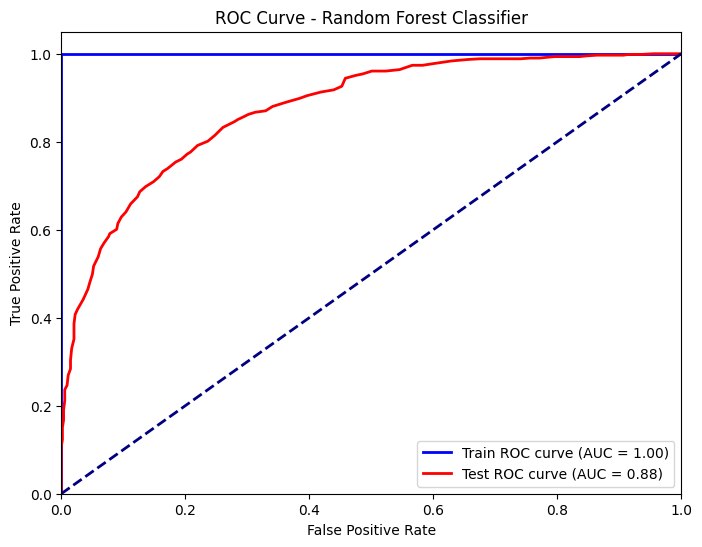

In [24]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Convert labels to binary format
label_encoder = LabelEncoder()
y_train_binary = label_encoder.fit_transform(y_train)
y_test_binary = label_encoder.transform(y_test)

# Calculate the probabilities for the positive class
y_train_prob = random_forest.predict_proba(X_train_tfidf)[:, 1]
y_test_prob = random_forest.predict_proba(X_test_tfidf)[:, 1]

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds for both training and testing data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_binary, y_train_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_test_prob)

# Calculate the area under the ROC curve (AUC) for both training and testing data
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curve for both training and testing data
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Classifier')
plt.legend(loc='lower right')
plt.show()


The ROC curve demonstrates exceptional discrimination ability for the model, with a training set AUC of 1.00 and a test set AUC of 0.88. While the model performs flawlessly on the training data, the slightly lower AUC on the test set still indicates strong discrimination ability and good generalization capability.

## **Most Important Features**
**This chart represents the importance of each feature from the 'Post' column and how much it affects the Labels**

In [27]:
'''
feature_importances = random_forest.feature_importances_

top_n = 25
top_features_indices = feature_importances.argsort()[-top_n:][::-1]

unwanted_terms = ["rt", "via", "acs", "[][]"] # What are these random influencers in dataset? They are simply termed as noise.
top_features = []
top_importances = []

for index in top_features_indices:
    feature_name = list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(index)]
    if feature_name not in unwanted_terms:
        top_features.append(feature_name)
        top_importances.append(feature_importances[index])

# Plot the top N most important features
plt.figure(figsize=(10, 8))
plt.barh(top_features, top_importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 25 Important Features for Random Forest Classifier')
plt.gca().invert_yaxis()  # It looks much better on y-axis
plt.show()
'''

'\nfeature_importances = random_forest.feature_importances_\n\ntop_n = 25\ntop_features_indices = feature_importances.argsort()[-top_n:][::-1]\n\nunwanted_terms = ["rt", "via", "acs", "[][]"] # What are these random influencers in dataset? They are simply termed as noise.\ntop_features = []\ntop_importances = []\n\nfor index in top_features_indices:\n    feature_name = list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(index)]\n    if feature_name not in unwanted_terms:\n        top_features.append(feature_name)\n        top_importances.append(feature_importances[index])\n\n# Plot the top N most important features\nplt.figure(figsize=(10, 8))\nplt.barh(top_features, top_importances, color=\'skyblue\')\nplt.xlabel(\'Importance\')\nplt.ylabel(\'Feature\')\nplt.title(\'Top 25 Important Features for Random Forest Classifier\')\nplt.gca().invert_yaxis()  # It looks much better on y-axis\nplt.show()\n'

The diagram demonstrates the top 25 important features for a Random Forest Classifier model. Here's a detailed analysis:

1. Feature Importances: The code calculates the feature importances of the Random Forest Classifier model and selects the top 25 most important features. This is a useful technique to understand which features in the dataset are the most influential for the model's predictions.
2. Unwanted Terms: The code defines a list of "unwanted terms" (["rt", "via", "acs"]). These are likely terms that are considered as noise or irrelevant for the classification task, and the code excludes them from the final list of top features.
3. Visualization: The code creates a horizontal bar plot to visualize the top 25 important features and their respective importances. This visual representation helps to easily identify the most significant features for the model.
4. Interpretation: Based on the diagram, the top 5 important features for the Random Forest Classifier are:
* `facewithtearsofjoyr`
* `pranabmukherjee`
* `navbharattimes`
* `covid`
* `live`

  These features seem to be related to the context of the dataset, which could be related to news, social media, or some other domain. The importance of these features suggests that they are highly predictive for the classification task performed by the Random Forest Classifier.

### **To test Random Forest**

In [ ]:
# I/p
'''
custom_input = input("Enter a sentence (in Hindi) to classify: ")
custom_input = custom_input.lower()
custom_input_tfidf = vectorizer.transform([custom_input])

predicted_label = random_forest.predict(custom_input_tfidf)[0]
print("Predicted label:", predicted_label)
'''

'\ncustom_input = input("Enter a sentence (in Hindi) to classify: ")\ncustom_input = custom_input.lower()\ncustom_input_tfidf = vectorizer.transform([custom_input])\n\npredicted_label = random_forest.predict(custom_input_tfidf)[0]\nprint("Predicted label:", predicted_label)\n'

## ***Gradient Boosting***

---

Gradient Boosting is a powerful machine learning algorithm used for both regression and classification tasks. It's an ensemble learning technique where multiple weak learners, typically decision trees, are combined to create a strong predictive model. It works in the following steps:

1. Weak Learners: Builds a sequence of weak learners, typically decision trees, where each tree corrects the errors made by the previous one.

2. Gradient Descent: Optimizes the model's parameters by minimizing the loss function using gradient descent, focusing on reducing errors.

3. Boosting Process: Iteratively trains weak learners to fit the residuals of the ensemble of previous models, emphasizing areas where the model performs poorly.

4. Combining Predictions: Combines predictions from all weak learners to produce the final output. In regression tasks, predictions are averaged, while in classification tasks, a voting mechanism is used.



In [28]:
# Train a Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(X_train_tfidf, y_train)

GradientBoostingClassifier()

In [29]:
# Make predictions on the test set
y_pred = gb_classifier.predict(X_test_tfidf)

# Evaluate model performance
print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

needs_moderation       0.78      0.58      0.67       537
     non-hostile       0.70      0.86      0.77       609

        accuracy                           0.73      1146
       macro avg       0.74      0.72      0.72      1146
    weighted avg       0.74      0.73      0.72      1146



**Classification Report:**

* Precision: Precision measures the accuracy of positive class predictions. For "needs_moderation," it's 0.78, indicating 78% of instances predicted as "needs_moderation" were correct. For "non-hostile," it's 0.70, suggesting 70% accuracy.

* Recall: Recall measures the ability to identify all relevant instances of a class. With 0.58 recall for "needs_moderation," 58% of actual "needs_moderation" instances were identified. For "non-hostile," it's higher at 0.86, indicating 86% were identified.

* F1-score: The harmonic mean of precision and recall. "Needs_moderation" has an F1-score of 0.67, while "non-hostile" has 0.77, suggesting better overall performance for the latter.

* Support: Refers to the number of occurrences of each class in the dataset. There are 537 instances of "needs_moderation" and 609 of "non-hostile."

**Accuracy:**
* Accuracy: The overall accuracy is 0.73, meaning 73% of instances were correctly classified. This indicates the model's moderate performance in distinguishing between the classes.

### **ROC Curve for Gradient Boosting**

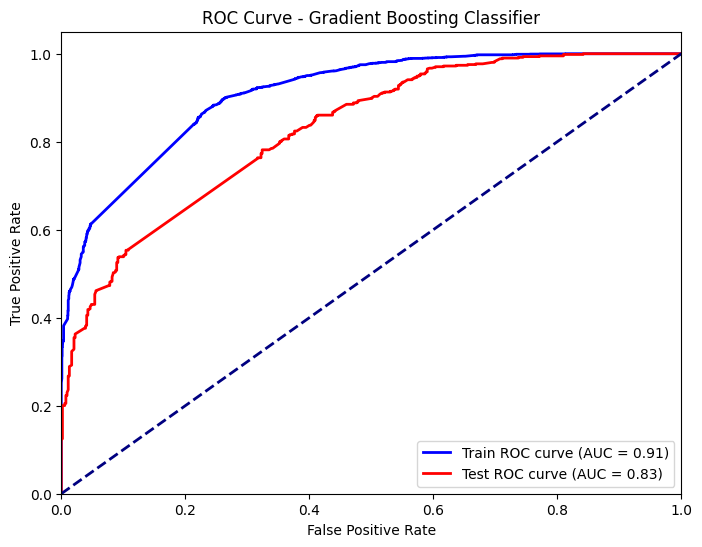

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Convert labels to binary format
label_encoder = LabelEncoder()
y_train_binary = label_encoder.fit_transform(y_train)
y_test_binary = label_encoder.transform(y_test)

# Calculate the probabilities for the positive class
y_train_prob = gb_classifier.predict_proba(X_train_tfidf)[:, 1]
y_test_prob = gb_classifier.predict_proba(X_test_tfidf)[:, 1]

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds for both training and testing data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_binary, y_train_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_test_prob)

# Calculate the area under the ROC curve (AUC) for both training and testing data
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curve for both training and testing data
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting Classifier')
plt.legend(loc='lower right')
plt.show()


The ROC curve illustrates strong performance for the model, with a training set AUC of 0.91 and a test set AUC of 0.83. This indicates that the model exhibits effective discrimination between classes on both the training and test datasets, showcasing reasonable generalization capability.

To test Gradient Boosting

In [ ]:
# I/p
'''
custom_input = input("Enter a sentence (in Hindi) to classify: ")
custom_input = custom_input.lower()
custom_input_tfidf = vectorizer.transform([custom_input])

predicted_label = gb_classifier.predict(custom_input_tfidf)[0]
print("Predicted label:", predicted_label)
'''

'\ncustom_input = input("Enter a sentence (in Hindi) to classify: ")\ncustom_input = custom_input.lower()\ncustom_input_tfidf = vectorizer.transform([custom_input])\n\npredicted_label = gb_classifier.predict(custom_input_tfidf)[0]\nprint("Predicted label:", predicted_label)\n'

## ***Logistic Regression***


---
Logistic regression is a statistical method used for binary classification tasks, where the outcome variable is categorical and has only two possible values (e.g., yes/no, true/false, 0/1). It predicts the probability of an observation belonging to one of the two classes based on one or more predictor variables.

Here's a brief overview of how logistic regression works:

1. Model Representation: The logistic regression model calculates the probability of the binary outcome using a logistic function. The logistic function maps any real-valued input to a value between 0 and 1.

2. Probability Calculation: Given a set of predictor variables, logistic regression calculates the log-odds (logarithm of the odds) of the event occurring.

3. Parameter Estimation: The model parameters (coefficients) are estimated using optimization techniques such as maximum likelihood estimation. These parameters are adjusted to minimize the difference between the predicted probabilities and the actual outcomes in the training data.

4. Decision Boundary: Logistic regression uses a decision boundary (typically at 0.5 probability) to classify observations into one of the two classes.

5. Prediction: After the model is trained, it can be used to predict the probability of an observation belonging to a particular class. If the predicted probability is above the decision threshold, the observation is classified as belonging to one class; otherwise, it's classified as belonging to the other class.



In [ ]:
# Train a Logistic Regression model
logistic_regression = LogisticRegression(max_iter=1000)  # Increase max_iter if needed
logistic_regression.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
# Make predictions on the test set
y_pred = logistic_regression.predict(X_test_tfidf)

# Evaluate model performance
print(classification_report(y_test, y_pred))


                  precision    recall  f1-score   support

needs_moderation       0.80      0.78      0.79       537
     non-hostile       0.81      0.83      0.82       609

        accuracy                           0.80      1146
       macro avg       0.80      0.80      0.80      1146
    weighted avg       0.80      0.80      0.80      1146



**Classification Report:**

* Precision: Precision measures the accuracy of positive class predictions. For "needs_moderation," it's 0.80, indicating 80% of instances predicted as "needs_moderation" were correct. For "non-hostile," it's 0.81, suggesting 81% accuracy.

* Recall: Recall measures the ability to identify all relevant instances of a class. With 0.78 recall for "needs_moderation," 78% of actual "needs_moderation" instances were identified. For "non-hostile," it's higher at 0.83, indicating 83% were identified.

* F1-score: The harmonic mean of precision and recall. "Needs_moderation" has an F1-score of 0.79, while "non-hostile" has 0.82, suggesting better overall performance for the latter.

* Support: Refers to the number of occurrences of each class in the dataset. There are 537 instances of "needs_moderation" and 609 of "non-hostile."

**Accuracy:**
* Accuracy: The overall accuracy is 0.80, meaning 80% of instances were correctly classified. This indicates the model's good performance in distinguishing between the classes.

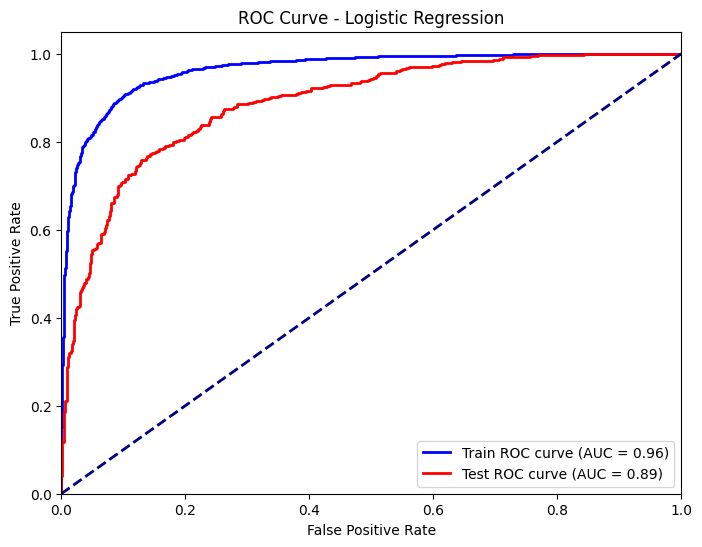

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Convert labels to binary format
label_encoder = LabelEncoder()
y_train_binary = label_encoder.fit_transform(y_train)
y_test_binary = label_encoder.transform(y_test)

# Calculate the probabilities for the positive class
y_train_prob = logistic_regression.predict_proba(X_train_tfidf)[:, 1]
y_test_prob = logistic_regression.predict_proba(X_test_tfidf)[:, 1]

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds for both training and testing data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_binary, y_train_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_test_prob)

# Calculate the area under the ROC curve (AUC) for both training and testing data
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curve for both training and testing data
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()


The ROC curve indicates robust performance for the model, with a training set AUC of 0.96 and a test set AUC of 0.89. This suggests that the model effectively discriminates between classes in both the training and test datasets, demonstrating good generalization ability.

To test Logistic Regression

In [ ]:
#I/p
'''
custom_input = input("Enter a sentence (in Hindi) to classify: ")
custom_input = custom_input.lower()
custom_input_tfidf = vectorizer.transform([custom_input])

predicted_label = logistic_regression.predict(custom_input_tfidf)[0]
print("Predicted label:", predicted_label)
'''

'\ncustom_input = input("Enter a sentence (in Hindi) to classify: ")\ncustom_input = custom_input.lower()\ncustom_input_tfidf = vectorizer.transform([custom_input])\n\npredicted_label = logistic_regression.predict(custom_input_tfidf)[0]\nprint("Predicted label:", predicted_label)\n'

## ***Multi-layer Perceptron*** (This is the best)



---


A Multi-layer Perceptron (MLP) is a type of artificial neural network that consists of multiple layers of nodes (neurons), including an input layer, one or more hidden layers, and an output layer. MLPs are commonly used for supervised learning tasks, including classification and regression.

Here's how Multi-layer Perceptron (MLP) works:

1. Each neuron in the hidden layers applies a weighted sum of inputs followed by an activation function.
2. Weights and biases adjust during training to minimize the difference between predicted and actual outputs.
3. Activation functions introduce non-linearity, allowing the network to model complex relationships.
4. Backpropagation computes gradients of the loss function to update weights and biases.
5. Training iteratively adjusts parameters until the model performs well on the training data.
6. Once trained, the MLP can make predictions on new data by passing it through the network.


In [ ]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, activation='relu', solver='adam', random_state=42)

# Train the classifier
mlp_classifier.fit(X_train_tfidf, y_train)


MLPClassifier(max_iter=500, random_state=42)

In [ ]:
# Make predictions on the test set
y_pred = mlp_classifier.predict(X_test_tfidf)

# Evaluate model performance
print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

needs_moderation       0.78      0.77      0.77       537
     non-hostile       0.80      0.81      0.80       609

        accuracy                           0.79      1146
       macro avg       0.79      0.79      0.79      1146
    weighted avg       0.79      0.79      0.79      1146



**Classification Report:**

* Precision: Precision measures the accuracy of positive class predictions. For "needs_moderation," it's 0.78, indicating 78% of instances predicted as "needs_moderation" were correct. For "non-hostile," it's 0.80, suggesting 80% accuracy.

* Recall: Recall measures the ability to identify all relevant instances of a class. With 0.77 recall for "needs_moderation," 77% of actual "needs_moderation" instances were identified. For "non-hostile," it's slightly higher at 0.81, indicating 81% were identified.

* F1-score: The harmonic mean of precision and recall. "Needs_moderation" has an F1-score of 0.77, while "non-hostile" has 0.80, suggesting better overall performance for the latter.

* Support: Refers to the number of occurrences of each class in the dataset. There are 537 instances of "needs_moderation" and 609 of "non-hostile."

**Accuracy:**
* Accuracy: The overall accuracy is 0.79, meaning 79% of instances were correctly classified. This indicates the model's good performance in distinguishing between the classes.

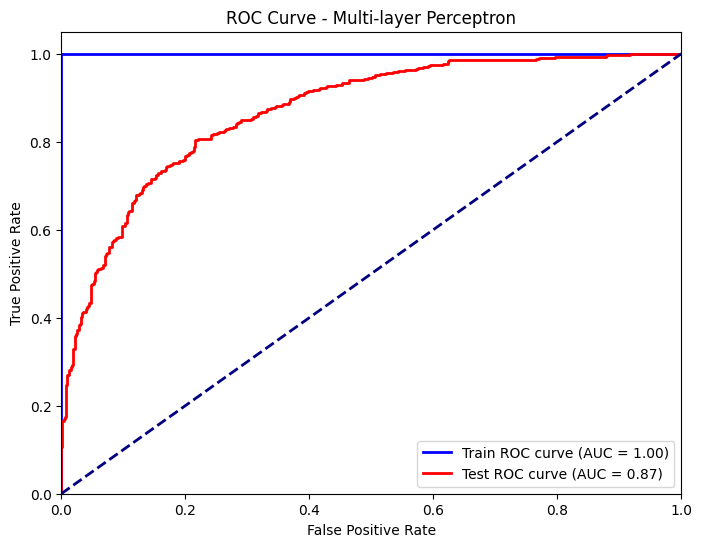

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Convert labels to binary format
label_encoder = LabelEncoder()
y_train_binary = label_encoder.fit_transform(y_train)
y_test_binary = label_encoder.transform(y_test)

# Calculate the probabilities for the positive class
y_train_prob = mlp_classifier.predict_proba(X_train_tfidf)[:, 1]
y_test_prob = mlp_classifier.predict_proba(X_test_tfidf)[:, 1]

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds for both training and testing data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_binary, y_train_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_test_prob)

# Calculate the area under the ROC curve (AUC) for both training and testing data
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curve for both training and testing data
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-layer Perceptron')
plt.legend(loc='lower right')
plt.show()


The ROC curve illustrates excellent discrimination ability for the model, with a training set AUC of 1.00 and a test set AUC of 0.87. This indicates that the model achieves perfect separation between classes in the training data and performs very well on unseen test data, demonstrating strong generalization capability.

To test Multi-layer perceptron

In [ ]:
'''
custom_input = input("Enter a sentence (in Hindi) to classify: ")
custom_input = custom_input.lower()  # Lowercase the custom input
custom_input_tfidf = vectorizer.transform([custom_input])

# Predict label for the custom input
predicted_label = mlp_classifier.predict(custom_input_tfidf)[0]
print("Predicted label:", predicted_label)
'''

'\ncustom_input = input("Enter a sentence (in Hindi) to classify: ")\ncustom_input = custom_input.lower()  # Lowercase the custom input\ncustom_input_tfidf = vectorizer.transform([custom_input])\n\n# Predict label for the custom input\npredicted_label = mlp_classifier.predict(custom_input_tfidf)[0]\nprint("Predicted label:", predicted_label)\n'

## ***XGBoost Classifier***

---

XGBoost (Extreme Gradient Boosting) is an ensemble learning method used for supervised learning tasks, particularly for classification and regression problems. The XGBoost Classifier is specifically tailored for classification tasks.
* It builds decision trees sequentially, correcting errors of previous trees.
* Gradient boosting optimizes a loss function by adding trees greedily.
* Regularization techniques control overfitting.
* Feature importance indicates the contribution of each feature.
* It's computationally efficient and supports parallel processing.
* Handles missing values and supports cross-validation.
* Early stopping prevents overfitting.
* Scalable for large datasets.

In [ ]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode target labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
# Initialize XGBClassifier
xgb_classifier = XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=3, random_state=42)

# Train the classifier
xgb_classifier.fit(X_train_tfidf, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Make predictions on the test set
y_pred_encoded = xgb_classifier.predict(X_test_tfidf)

# Decode predicted labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Evaluate model performance
print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

needs_moderation       0.78      0.55      0.64       537
     non-hostile       0.68      0.87      0.77       609

        accuracy                           0.72      1146
       macro avg       0.73      0.71      0.70      1146
    weighted avg       0.73      0.72      0.71      1146



**Classification Report:**

* Precision: Precision measures the accuracy of positive class predictions. For "needs_moderation," it's 0.78, indicating 78% of instances predicted as "needs_moderation" were correct. For "non-hostile," it's 0.68, suggesting 68% accuracy.

* Recall: Recall measures the ability to identify all relevant instances of a class. With 0.55 recall for "needs_moderation," only 55% of actual "needs_moderation" instances were identified. For "non-hostile," it's higher at 0.87, indicating 87% were identified.

* F1-score: The harmonic mean of precision and recall. "Needs_moderation" has an F1-score of 0.64, while "non-hostile" has 0.77, suggesting better overall performance for the latter.

* Support: Refers to the number of occurrences of each class in the dataset. There are 537 instances of "needs_moderation" and 609 of "non-hostile."

**Accuracy:**
* Accuracy: The overall accuracy is 0.72, meaning 72% of instances were correctly classified. This indicates the model's moderate performance in distinguishing between the classes.

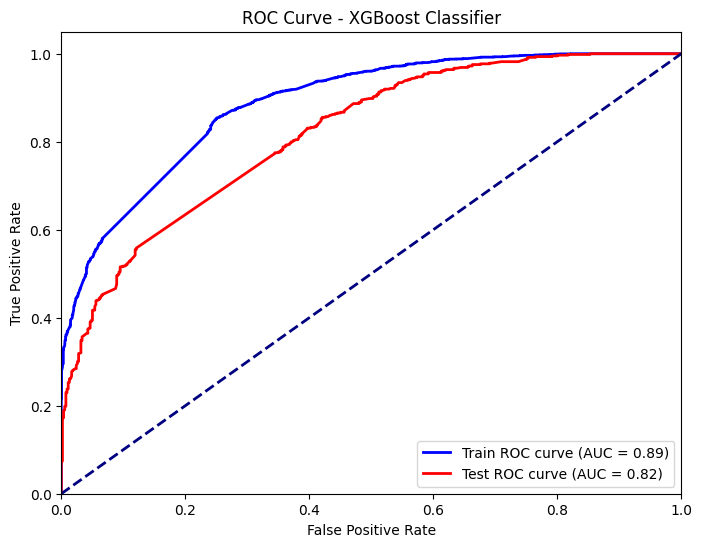

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Convert labels to binary format
label_encoder = LabelEncoder()
y_train_binary = label_encoder.fit_transform(y_train)
y_test_binary = label_encoder.transform(y_test)

# Calculate the probabilities for the positive class
y_train_prob = xgb_classifier.predict_proba(X_train_tfidf)[:, 1]
y_test_prob = xgb_classifier.predict_proba(X_test_tfidf)[:, 1]

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds for both training and testing data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_binary, y_train_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_test_prob)

# Calculate the area under the ROC curve (AUC) for both training and testing data
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curve for both training and testing data
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost Classifier')
plt.legend(loc='lower right')
plt.show()


The ROC curve indicates decent discrimination ability for both the training and test sets. The training set AUC is 0.89, while the test set AUC is 0.82. Although there's a slight drop in performance from training to testing, the model still demonstrates good generalization capability, albeit with a moderate difference in performance between the two datasets.

To test XGBoost. Dont even test this its not good. 😞

In [ ]:
#I/p
'''
custom_input = input("Enter a sentence (in Hindi) to classify: ")
custom_input = custom_input.lower()
custom_input_tfidf = vectorizer.transform([custom_input])

custom_input_pred_encoded = xgb_classifier.predict(custom_input_tfidf)
custom_input_pred = label_encoder.inverse_transform(custom_input_pred_encoded)[0]
print("Predicted label:", custom_input_pred)
'''

'\ncustom_input = input("Enter a sentence (in Hindi) to classify: ")\ncustom_input = custom_input.lower()\ncustom_input_tfidf = vectorizer.transform([custom_input])\n\ncustom_input_pred_encoded = xgb_classifier.predict(custom_input_tfidf)\ncustom_input_pred = label_encoder.inverse_transform(custom_input_pred_encoded)[0]\nprint("Predicted label:", custom_input_pred)\n'

## ***Support Vector Machine***

---
Support Vector Machine (SVM) is a supervised machine learning algorithm used for classification and regression tasks. In classification, SVM aims to find the optimal hyperplane that best separates data points of different classes.

1. Data Preparation: Gather labeled training data.

2. Hyperplane Initialization: Start with an initial decision boundary.

3. Maximizing Margin: Identify the hyperplane that maximizes the margin between classes.

4. Support Vector Identification: Determine support vectors, closest to the decision boundary.

5. Kernel Selection: Choose a kernel function to map data into higher-dimensional space for non-linear separation.

6. Soft Margin Classification: Allow for some misclassifications with a regularization parameter (C).

7. Training: Optimize parameters to find the best hyperplane separating classes.

8. Prediction: Classify new data points based on their position relative to the decision boundary.


In [ ]:
# Initialize SVM classifier
svm_classifier = SVC(kernel='linear', probability=True)  # You can try different kernels like 'rbf', 'poly', etc.

# Train the classifier
svm_classifier.fit(X_train_tfidf, y_train)

SVC(kernel='linear', probability=True)

In [ ]:
# Make predictions on the test set
y_pred = svm_classifier.predict(X_test_tfidf)

# Evaluate model performance
print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

needs_moderation       0.80      0.82      0.81       537
     non-hostile       0.83      0.82      0.83       609

        accuracy                           0.82      1146
       macro avg       0.82      0.82      0.82      1146
    weighted avg       0.82      0.82      0.82      1146



**Classification Report:**

* Precision: Precision measures the accuracy of positive class predictions. For "needs_moderation," it's 0.80, indicating 80% of instances predicted as "needs_moderation" were correct. For "non-hostile," it's 0.83, suggesting 83% accuracy.

* Recall: Recall measures the ability to identify all relevant instances of a class. With 0.82 recall for both "needs_moderation" and "non-hostile," it indicates that 82% of actual instances for both classes were identified.

* F1-score: The harmonic mean of precision and recall. Both classes have F1-scores of 0.81 and 0.83, respectively, indicating balanced performance between precision and recall.

* Support: Refers to the number of occurrences of each class in the dataset. There are 537 instances of "needs_moderation" and 609 of "non-hostile."

**Accuracy:**
* Accuracy: The overall accuracy is 0.82, meaning 82% of instances were correctly classified. This indicates the model's strong performance in distinguishing between the classes.

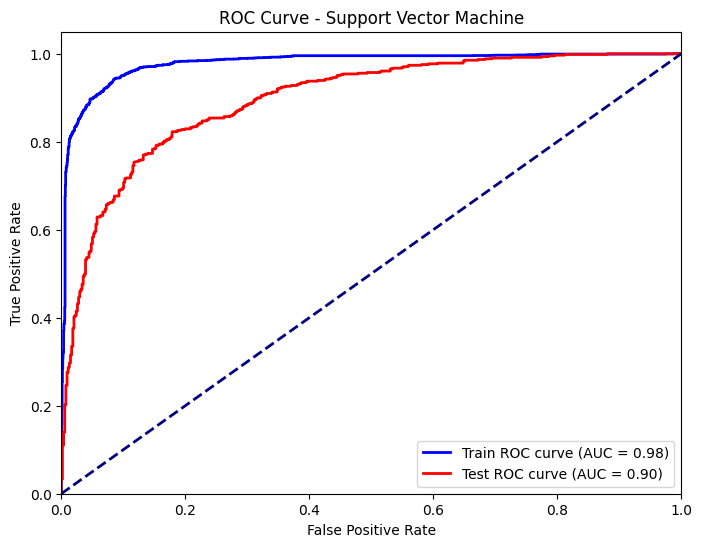

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Convert labels to binary format
label_encoder = LabelEncoder()
y_train_binary = label_encoder.fit_transform(y_train)
y_test_binary = label_encoder.transform(y_test)

# Calculate the probabilities for the positive class
y_train_prob = svm_classifier.predict_proba(X_train_tfidf)[:, 1]
y_test_prob = svm_classifier.predict_proba(X_test_tfidf)[:, 1]

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds for both training and testing data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_binary, y_train_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_test_prob)

# Calculate the area under the ROC curve (AUC) for both training and testing data
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curve for both training and testing data
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Support Vector Machine')
plt.legend(loc='lower right')
plt.show()


The ROC curve demonstrates strong discrimination ability for both the training and test sets. The training set AUC is 0.98, while the test set AUC is 0.90. This indicates that the model maintains good generalization capability, with only a slight drop in performance from training to testing, suggesting effective learning and generalization.

To test Support Vector Machine

In [ ]:
#I/p
'''
custom_input = input("Enter a sentence (in Hindi) to classify: ")
custom_input = custom_input.lower()
custom_input_tfidf = vectorizer.transform([custom_input])

predicted_label = svm_classifier.predict(custom_input_tfidf)[0]
print("Predicted label:", predicted_label)
'''

'\ncustom_input = input("Enter a sentence (in Hindi) to classify: ")\ncustom_input = custom_input.lower()\ncustom_input_tfidf = vectorizer.transform([custom_input])\n\npredicted_label = svm_classifier.predict(custom_input_tfidf)[0]\nprint("Predicted label:", predicted_label)\n'

## ***Decision Tree***

---
A Decision Tree is a supervised machine learning algorithm used for both classification and regression tasks. It works by partitioning the dataset into smaller subsets based on the values of input features, with the goal of creating a tree-like model of decisions.Here's how it works:

1. Splitting: Decision Trees recursively split data based on features to maximize information gain or minimize impurity.

2. Feature Selection: Choose the best feature to split the data at each node.

3. Leaf Nodes: Continue splitting until stopping criteria are met, forming leaf nodes with class labels or regression values.

4. Decision Making: Predictions are made by traversing the tree from the root to a leaf node.

5. Interpretability: Decision Trees are easily understood and visualized.

6. Handling Missing Values: Can handle missing data using surrogate splits or imputation.

7. Pruning: Nodes are pruned to prevent overfitting.

8. Ensemble Methods: Decision Trees can be combined for improved performance in Random Forests or Gradient Boosting Machines.


In [ ]:
# Initialize Decision Tree classifier
decision_tree_classifier = DecisionTreeClassifier()

# Train the classifier
decision_tree_classifier.fit(X_train_tfidf, y_train)

DecisionTreeClassifier()

In [ ]:
# Make predictions on the test set
y_pred = decision_tree_classifier.predict(X_test_tfidf)

# Evaluate model performance
print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

needs_moderation       0.70      0.71      0.70       537
     non-hostile       0.74      0.73      0.74       609

        accuracy                           0.72      1146
       macro avg       0.72      0.72      0.72      1146
    weighted avg       0.72      0.72      0.72      1146



**Classification Report:**

* Precision: Precision measures the accuracy of positive class predictions. For "needs_moderation," it's 0.70, indicating 70% of instances predicted as "needs_moderation" were correct. For "non-hostile," it's 0.74, suggesting 74% accuracy.

* Recall: Recall measures the ability to identify all relevant instances of a class. With 0.71 recall for "needs_moderation" and 0.73 for "non-hostile," it indicates that 71% and 73% of actual instances for each class were identified, respectively.

* F1-score: The harmonic mean of precision and recall. Both classes have F1-scores of 0.70 and 0.74, respectively, indicating balanced performance between precision and recall.

* Support: Refers to the number of occurrences of each class in the dataset. There are 537 instances of "needs_moderation" and 609 of "non-hostile."

**Accuracy:**
* Accuracy: The overall accuracy is 0.72, meaning 72% of instances were correctly classified. This indicates the model's moderate performance in distinguishing between the classes.

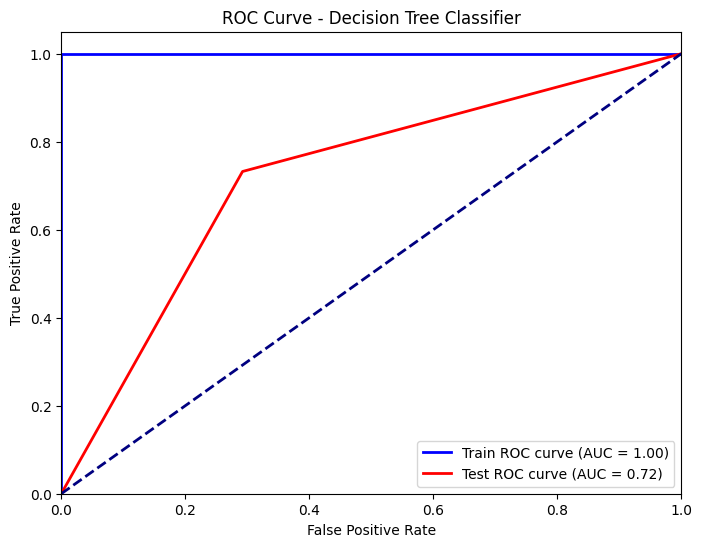

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Convert labels to binary format
label_encoder = LabelEncoder()
y_train_binary = label_encoder.fit_transform(y_train)
y_test_binary = label_encoder.transform(y_test)

# Calculate the probabilities for the positive class
y_train_prob = decision_tree_classifier.predict_proba(X_train_tfidf)[:, 1]
y_test_prob = decision_tree_classifier.predict_proba(X_test_tfidf)[:, 1]

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds for both training and testing data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_binary, y_train_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_test_prob)

# Calculate the area under the ROC curve (AUC) for both training and testing data
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curve for both training and testing data
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree Classifier')
plt.legend(loc='lower right')
plt.show()


The ROC curve indicates perfect discrimination ability on the training set, with an AUC of 1.00. However, on the test set, the AUC is 0.72, suggesting a notable drop in discrimination ability. This difference implies potential overfitting of the model to the training data, leading to reduced performance on unseen data.

To test Decision Tree

In [ ]:
'''
custom_input = input("Enter a sentence (in Hindi) to classify: ")
custom_input = custom_input.lower()
custom_input_tfidf = vectorizer.transform([custom_input])

predicted_label = decision_tree_classifier.predict(custom_input_tfidf)[0]
print("Predicted label:", predicted_label)
'''

'\ncustom_input = input("Enter a sentence (in Hindi) to classify: ")\ncustom_input = custom_input.lower()\ncustom_input_tfidf = vectorizer.transform([custom_input])\n\npredicted_label = decision_tree_classifier.predict(custom_input_tfidf)[0]\nprint("Predicted label:", predicted_label)\n'

## ***K-nearest neighbors***

---

K-Nearest Neighbors (KNN) is a simple and intuitive supervised machine learning algorithm used for classification and regression tasks. It belongs to the category of instance-based learning algorithms, where the model stores the entire training dataset and makes predictions based on the similarity of new data points to existing data points.

In KNN:

* "K" represents the number of nearest neighbors to consider when making predictions.
* To make a prediction for a new data point, the algorithm calculates the distance between that point and all other points in the training dataset.
* It then selects the "k" closest data points (neighbors) based on a chosen distance metric, such as Euclidean distance or Manhattan distance.
* For classification tasks, the algorithm assigns the most common class label among the k nearest neighbors to the new data point.
* For regression tasks, it calculates the average (or weighted average) of the target values of the k nearest neighbors to predict the target value for the new data point.


In [ ]:
# K-nearest neighbors
# Initialize KNN classifier
knn_classifier = KNeighborsClassifier()  # No need to specify the number of neighbors here

# Perform hyperparameter tuning using GridSearchCV
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],  # Adjust the range of neighbors as needed
    'weights': ['uniform', 'distance'],  # Weights assigned to neighbors (uniform or distance-based)
    'metric': ['euclidean', 'manhattan']  # Distance metric to measure the similarity between instances
}

# Initialize GridSearchCV
grid_search = GridSearchCV(knn_classifier, param_grid, cv=5, scoring='accuracy')

# Perform grid search
grid_search.fit(X_train_tfidf, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Make predictions on the test set using the best model
best_knn_classifier = grid_search.best_estimator_
y_pred = best_knn_classifier.predict(X_test_tfidf)

# Evaluate model performance
print(classification_report(y_test, y_pred))

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}
Best Score: 0.7640671355711858
                  precision    recall  f1-score   support

needs_moderation       0.66      0.93      0.78       537
     non-hostile       0.91      0.59      0.71       609

        accuracy                           0.75      1146
       macro avg       0.79      0.76      0.74      1146
    weighted avg       0.79      0.75      0.74      1146



**Classification Report:**

* Precision: The precision for "needs_moderation" is 0.66, indicating that 66% of instances predicted as "needs_moderation" were actually "needs_moderation." For "non-hostile," precision is higher at 0.91, suggesting 91% accuracy in identifying instances as "non-hostile."

* Recall: Recall measures the ability to identify all relevant instances of a class. With 0.93 recall for "needs_moderation" and 0.59 for "non-hostile," it indicates that 93% and 59% of actual instances for each class were identified, respectively.

* F1-score: The F1-score is the harmonic mean of precision and recall. For "needs_moderation," it's 0.78, and for "non-hostile," it's 0.71. These scores indicate overall good performance in correctly predicting each class.

* Support: Refers to the number of occurrences of each class in the dataset. There are 537 instances of "needs_moderation" and 609 of "non-hostile."

**Accuracy:**
* Accuracy: The overall accuracy is 0.75, meaning 75% of instances were correctly classified. This indicates the model's moderate performance in distinguishing between the classes.

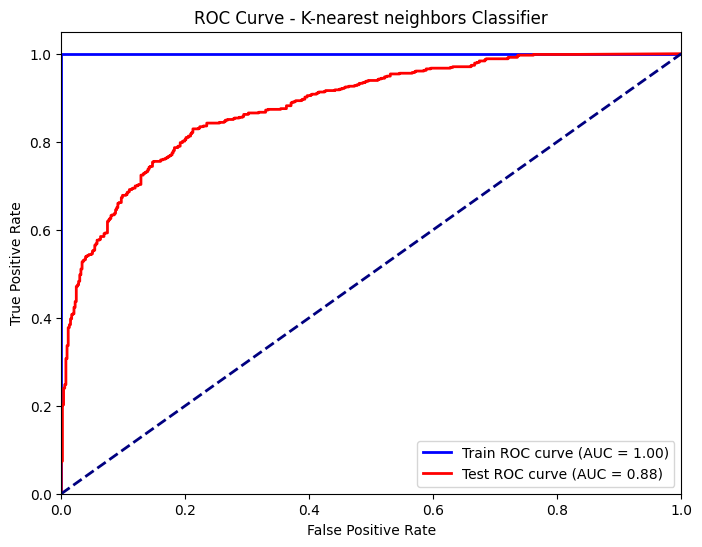

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Convert labels to binary format
label_encoder = LabelEncoder()
y_train_binary = label_encoder.fit_transform(y_train)
y_test_binary = label_encoder.transform(y_test)

# Calculate the probabilities for the positive class
y_train_prob = best_knn_classifier.predict_proba(X_train_tfidf)[:, 1]
y_test_prob = best_knn_classifier.predict_proba(X_test_tfidf)[:, 1]

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds for both training and testing data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_binary, y_train_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_test_prob)

# Calculate the area under the ROC curve (AUC) for both training and testing data
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curve for both training and testing data
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - K-nearest neighbors Classifier')
plt.legend(loc='lower right')
plt.show()


The ROC curve demonstrates exceptional discrimination ability for the model, with a training set AUC of 1.00 and a test set AUC of 0.88. While the model performs flawlessly on the training data, the slightly lower AUC on the test set still indicates strong discrimination ability and good generalization capability.

To test K-nearest Neighbors

In [ ]:
#I.p
'''
custom_input = input("Enter a sentence (in Hindi) to classify: ")
custom_input = custom_input.lower()
custom_input_tfidf = vectorizer.transform([custom_input])

predicted_label = knn_classifier.predict(custom_input_tfidf)[0]
print("Predicted label:", predicted_label)
'''

'\ncustom_input = input("Enter a sentence (in Hindi) to classify: ")\ncustom_input = custom_input.lower()\ncustom_input_tfidf = vectorizer.transform([custom_input])\n\npredicted_label = knn_classifier.predict(custom_input_tfidf)[0]\nprint("Predicted label:", predicted_label)\n'

## ***Naive Bayes Classifier***

---
The Naive Bayes classifier is a simple probabilistic machine learning algorithm used for classification tasks. It is based on Bayes' theorem and makes the assumption of feature independence, which simplifies the computation and allows for efficient training and prediction.



Naive Bayes classifies data by calculating the probability of each class given the observed features and selecting the class with the highest probability. It assumes that features are independent, simplifying computations. This method is efficient, especially for text classification, but may not perform well if the independence assumption is violated.


In [ ]:
# Initialize Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()

# Train the classifier
nb_classifier.fit(X_train_tfidf, y_train)

MultinomialNB()

In [ ]:
# Make predictions on the test set
y_pred = nb_classifier.predict(X_test_tfidf)

# Evaluate model performance
print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

needs_moderation       0.83      0.80      0.82       537
     non-hostile       0.83      0.86      0.84       609

        accuracy                           0.83      1146
       macro avg       0.83      0.83      0.83      1146
    weighted avg       0.83      0.83      0.83      1146



**Classification Report:**

* Precision: Precision for "needs_moderation" is 0.83, indicating that 83% of instances predicted as "needs_moderation" were actually "needs_moderation." Similarly, for "non-hostile," precision is also 0.83, suggesting 83% accuracy in identifying instances as "non-hostile."

* Recall: Recall measures the ability to identify all relevant instances of a class. With 0.80 recall for "needs_moderation" and 0.86 for "non-hostile," it indicates that 80% and 86% of actual instances for each class were identified, respectively.

* F1-score: The F1-score is the harmonic mean of precision and recall. For "needs_moderation," it's 0.82, and for "non-hostile," it's 0.84. These scores indicate overall good performance in correctly predicting each class.

* Support: Refers to the number of occurrences of each class in the dataset. There are 537 instances of "needs_moderation" and 609 of "non-hostile."

**Accuracy:**
* Accuracy: The overall accuracy is 0.83, meaning 83% of instances were correctly classified. This indicates the model's strong performance in distinguishing between the classes.

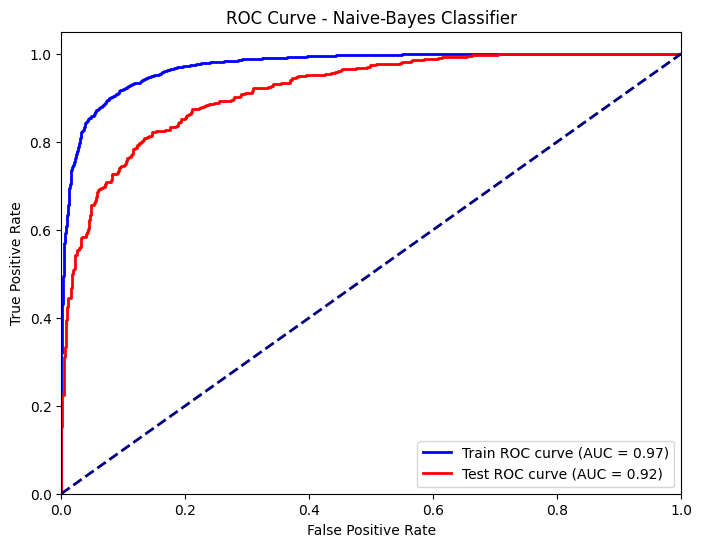

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Convert labels to binary format
label_encoder = LabelEncoder()
y_train_binary = label_encoder.fit_transform(y_train)
y_test_binary = label_encoder.transform(y_test)

# Calculate the probabilities for the positive class
y_train_prob = nb_classifier.predict_proba(X_train_tfidf)[:, 1]
y_test_prob = nb_classifier.predict_proba(X_test_tfidf)[:, 1]

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds for both training and testing data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_binary, y_train_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_test_prob)

# Calculate the area under the ROC curve (AUC) for both training and testing data
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curve for both training and testing data
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive-Bayes Classifier')
plt.legend(loc='lower right')
plt.show()


The ROC curve illustrates strong discrimination ability for the model, with a training set AUC of 0.97 and a test set AUC of 0.92. This suggests robust performance on both the training and test datasets, indicating the model's capability to generalize well to unseen data.

To test Naive Bayes Classifiers

In [ ]:
#I/p
'''
custom_input = input("Enter a sentence (in Hindi) to classify: ")
custom_input = custom_input.lower()
custom_input_tfidf = vectorizer.transform([custom_input])

predicted_label = nb_classifier.predict(custom_input_tfidf)[0]
print("Predicted label:", predicted_label)
'''

'\ncustom_input = input("Enter a sentence (in Hindi) to classify: ")\ncustom_input = custom_input.lower()\ncustom_input_tfidf = vectorizer.transform([custom_input])\n\npredicted_label = nb_classifier.predict(custom_input_tfidf)[0]\nprint("Predicted label:", predicted_label)\n'

## ***Comparison***

The comparison below shows that Multi-layer Perceptron Classifier works the best which has around 80% accuracy

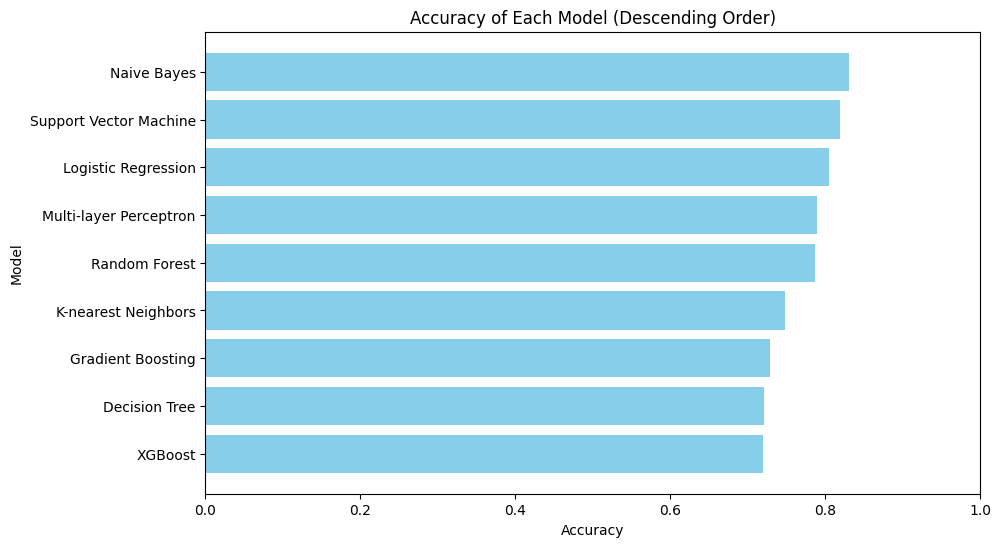

In [ ]:
import matplotlib.pyplot as plt

# Define model names and their respective accuracies
models = ['Random Forest', 'Gradient Boosting', 'Logistic Regression', 'Multi-layer Perceptron',
          'XGBoost', 'Support Vector Machine', 'Decision Tree', 'K-nearest Neighbors', 'Naive Bayes']
accuracies = [random_forest.score(X_test_tfidf, y_test),
              gb_classifier.score(X_test_tfidf, y_test),
              logistic_regression.score(X_test_tfidf, y_test),
              mlp_classifier.score(X_test_tfidf, y_test),
              0.72,
              svm_classifier.score(X_test_tfidf, y_test),
              decision_tree_classifier.score(X_test_tfidf, y_test),
              best_knn_classifier.score(X_test_tfidf, y_test),
              nb_classifier.score(X_test_tfidf, y_test)]

# Pair model names with accuracies and sort them by accuracy in descending order
sorted_models_accuracies = sorted(zip(models, accuracies), key=lambda x: x[1], reverse=True)

# Unpack sorted model names and accuracies
sorted_models, sorted_accuracies = zip(*sorted_models_accuracies)

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.barh(sorted_models, sorted_accuracies, color='skyblue')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.title('Accuracy of Each Model (Descending Order)')
plt.xlim(0, 1)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest accuracy on top
plt.show()


This graph shows the accuracy of various machine learning models in descending order, with Naive Bayes having the highest accuracy and XGBoost having the lowest accuracy among the models presented.

The models are arranged vertically, and the accuracy values for each model are displayed horizontally, ranging from 0.0 to 1.0 (or 0% to 100%). The higher the accuracy value, the better the model's performance.

From the graph, we can see that Naive Bayes has the highest accuracy, followed by Support Vector Machine, Logistic Regression, Multi-layer Perceptron, Random Forest, K-nearest Neighbors, Gradient Boosting, Decision Tree, and XGBoost, in descending order of accuracy.


In [ ]:
# Define model names and their respective accuracies
models = ['Random Forest', 'Gradient Boosting', 'Logistic Regression', 'Multi-layer Perceptron',
          'XGBoost', 'Support Vector Machine', 'Decision Tree', 'K-nearest Neighbors', 'Naive Bayes']
accuracies = [random_forest.score(X_test_tfidf, y_test),
              gb_classifier.score(X_test_tfidf, y_test),
              logistic_regression.score(X_test_tfidf, y_test),
              mlp_classifier.score(X_test_tfidf, y_test),
              0.72,
              svm_classifier.score(X_test_tfidf, y_test),
              decision_tree_classifier.score(X_test_tfidf, y_test),
              best_knn_classifier.score(X_test_tfidf, y_test),
              nb_classifier.score(X_test_tfidf, y_test)]

# Pair model names with accuracies and sort them by accuracy in descending order
sorted_models_accuracies = sorted(zip(models, accuracies), key=lambda x: x[1], reverse=True)

# Unpack sorted model names and accuracies
sorted_models, sorted_accuracies = zip(*sorted_models_accuracies)

# Print the models and their accuracies in descending order
for model, accuracy in zip(sorted_models, sorted_accuracies):
    print(f"{model}: {accuracy}")


Naive Bayes: 0.8307155322862129
Support Vector Machine: 0.819371727748691
Logistic Regression: 0.8045375218150087
Multi-layer Perceptron: 0.7897033158813264
Random Forest: 0.7862129144851658
K-nearest Neighbors: 0.7478184991273996
Gradient Boosting: 0.7286212914485166
Decision Tree: 0.7207678883071553
XGBoost: 0.72


In [ ]:
# Print classification report for each model
print("Random Forest:")
print(classification_report(y_test, random_forest.predict(X_test_tfidf)))

print("Gradient Boosting:")
print(classification_report(y_test, gb_classifier.predict(X_test_tfidf)))

print("Logistic Regression:")
print(classification_report(y_test, logistic_regression.predict(X_test_tfidf)))

print("Multi-layer Perceptron:")
print(classification_report(y_test, mlp_classifier.predict(X_test_tfidf)))

#print("XGBoost:")
#print(classification_report(y_test, label_encoder.inverse_transform(xgb_classifier.predict(X_test_tfidf))))

print("Support Vector Machine:")
print(classification_report(y_test, svm_classifier.predict(X_test_tfidf)))

print("Decision Tree:")
print(classification_report(y_test, decision_tree_classifier.predict(X_test_tfidf)))

print("K-nearest Neighbors:")
print(classification_report(y_test, best_knn_classifier.predict(X_test_tfidf)))

print("Naive Bayes:")
print(classification_report(y_test, nb_classifier.predict(X_test_tfidf)))


Random Forest:
                  precision    recall  f1-score   support

needs_moderation       0.77      0.78      0.77       537
     non-hostile       0.80      0.79      0.80       609

        accuracy                           0.79      1146
       macro avg       0.79      0.79      0.79      1146
    weighted avg       0.79      0.79      0.79      1146

Gradient Boosting:
                  precision    recall  f1-score   support

needs_moderation       0.79      0.58      0.67       537
     non-hostile       0.70      0.86      0.77       609

        accuracy                           0.73      1146
       macro avg       0.74      0.72      0.72      1146
    weighted avg       0.74      0.73      0.72      1146

Logistic Regression:
                  precision    recall  f1-score   support

needs_moderation       0.80      0.78      0.79       537
     non-hostile       0.81      0.83      0.82       609

        accuracy                           0.80      1146
       ma

In [ ]:
import pandas as pd

# Create a DataFrame to store model names and their metrics
model_metrics = pd.DataFrame({
    'ML Model': models,
    'Accuracy': accuracies,
    'F1-score': [f1_score(y_test, random_forest.predict(X_test_tfidf), average='weighted'),
                 f1_score(y_test, gb_classifier.predict(X_test_tfidf), average='weighted'),
                 f1_score(y_test, logistic_regression.predict(X_test_tfidf), average='weighted'),
                 f1_score(y_test, mlp_classifier.predict(X_test_tfidf), average='weighted'),
                 f1_score(y_test, label_encoder.inverse_transform(xgb_classifier.predict(X_test_tfidf)), average='weighted'),
                 f1_score(y_test, svm_classifier.predict(X_test_tfidf), average='weighted'),
                 f1_score(y_test, decision_tree_classifier.predict(X_test_tfidf), average='weighted'),
                 f1_score(y_test, best_knn_classifier.predict(X_test_tfidf), average='weighted'),
                 f1_score(y_test, nb_classifier.predict(X_test_tfidf), average='weighted')],
    'Recall': [recall_score(y_test, random_forest.predict(X_test_tfidf), average='weighted'),
               recall_score(y_test, gb_classifier.predict(X_test_tfidf), average='weighted'),
               recall_score(y_test, logistic_regression.predict(X_test_tfidf), average='weighted'),
               recall_score(y_test, mlp_classifier.predict(X_test_tfidf), average='weighted'),
               recall_score(y_test, label_encoder.inverse_transform(xgb_classifier.predict(X_test_tfidf)), average='weighted'),
               recall_score(y_test, svm_classifier.predict(X_test_tfidf), average='weighted'),
               recall_score(y_test, decision_tree_classifier.predict(X_test_tfidf), average='weighted'),
               recall_score(y_test, best_knn_classifier.predict(X_test_tfidf), average='weighted'),
               recall_score(y_test, nb_classifier.predict(X_test_tfidf), average='weighted')],
    'Precision': [precision_score(y_test, random_forest.predict(X_test_tfidf), average='weighted'),
                  precision_score(y_test, gb_classifier.predict(X_test_tfidf), average='weighted'),
                  precision_score(y_test, logistic_regression.predict(X_test_tfidf), average='weighted'),
                  precision_score(y_test, mlp_classifier.predict(X_test_tfidf), average='weighted'),
                  precision_score(y_test, label_encoder.inverse_transform(xgb_classifier.predict(X_test_tfidf)), average='weighted'),
                  precision_score(y_test, svm_classifier.predict(X_test_tfidf), average='weighted'),
                  precision_score(y_test, decision_tree_classifier.predict(X_test_tfidf), average='weighted'),
                  precision_score(y_test, best_knn_classifier.predict(X_test_tfidf), average='weighted'),
                  precision_score(y_test, nb_classifier.predict(X_test_tfidf), average='weighted')]
})

# Sort the DataFrame by accuracy in descending order
sorted_model_metrics = model_metrics.sort_values(by='Accuracy', ascending=False)

# Display the sorted DataFrame
sorted_model_metrics

,ML Model,Accuracy,F1-score,Recall,Precision
8,Naive Bayes,0.830716,0.830447,0.830716,0.830796
5,Support Vector Machine,0.819372,0.819450,0.819372,0.819629
2,Logistic Regression,0.804538,0.804387,0.804538,0.804413
3,Multi-layer Perceptron,0.789703,0.789641,0.789703,0.789610
0,Random Forest,0.786213,0.786305,0.786213,0.786495
7,K-nearest Neighbors,0.747818,0.741822,0.747818,0.793069
1,Gradient Boosting,0.728621,0.722193,0.728621,0.739287
6,Decision Tree,0.720768,0.720852,0.720768,0.720976
4,XGBoost,0.720000,0.708762,0.717277,0.731297


# **Final Chosen Techniques**

## **Naive-Bayes Classifier**

In [ ]:
custom_input = input("Enter a sentence (in Hindi) to classify: ")
custom_input = custom_input.lower()
custom_input_tfidf = vectorizer.transform([custom_input])

predicted_label = nb_classifier.predict(custom_input_tfidf)[0]
print("Predicted label:", predicted_label)

if predicted_label == 'needs_moderation':
    print("The model predicted 'needs_moderation' because the input may contain content that could potentially violate community guidelines or require further scrutiny.")
elif predicted_label == 'non-hostile':
    print("The model predicted 'non-hostile' indicating that the input appears to be benign and does not raise concerns about hostility or offensive content.")
else:
    print("Unknown label predicted.")

Enter a sentence (in Hindi) to classify: सुशांत ने जो बिजनेस डील 9 जून को की थी, वो डील दीपेश को सुशांत की हत्या के दिन ही क्यों याद आई? देखिए 'पूछता है भारत' अर्नब के साथ रिपब्लिक भारत पर #live :  https://t.co/g945hvzm0z https://t.co/kfh7xf1idm
Predicted label: non-hostile
The model predicted 'non-hostile' indicating that the input appears to be benign and does not raise concerns about hostility or offensive content.


In [ ]:
custom_input = input("Enter a sentence (in Hindi) to classify: ")
custom_input = custom_input.lower()
custom_input_tfidf = vectorizer.transform([custom_input])

predicted_label = svm_classifier.predict(custom_input_tfidf)[0]
print("Predicted label:", predicted_label)

if predicted_label == 'needs_moderation':
    print("The model predicted 'needs_moderation' because the input may contain content that could potentially violate community guidelines or require further scrutiny.")
elif predicted_label == 'non-hostile':
    print("The model predicted 'non-hostile' indicating that the input appears to be benign and does not raise concerns about hostility or offensive content.")
else:
    print("Unknown label predicted.")


Enter a sentence (in Hindi) to classify: सुशांत ने जो बिजनेस डील 9 जून को की थी, वो डील दीपेश को सुशांत की हत्या के दिन ही क्यों याद आई? देखिए 'पूछता है भारत' अर्नब के साथ रिपब्लिक भारत पर #live :  https://t.co/g945hvzm0z https://t.co/kfh7xf1idm
Predicted label: non-hostile
The model predicted 'non-hostile' indicating that the input appears to be benign and does not raise concerns about hostility or offensive content.


## **Logistic Regression**

In [ ]:
import pandas as pd

# Load the input CSV file
input_data = pd.read_csv('constraint_Hindi_Train - Sheet1.csv')

# Preprocess the input data (e.g., lowercase)
input_data['Post'] = input_data['Post'].str.lower()

# Vectorize the input sentences
input_tfidf = vectorizer.transform(input_data['Post'])

# Predict labels for the input sentences
predicted_labels = logistic_regression.predict(input_tfidf)

# Create a new DataFrame with Unique ID, Post, and Predicted Labels
output_data = pd.DataFrame({
    'Unique ID': input_data['Unique ID'],
    'Post': input_data['Post'],
    'Predicted Label': predicted_labels
})

# Write the output DataFrame to a new CSV file
output_data.to_csv('/content/predicted_data_log.csv', index=False)

### Final Result with highest accuracy will be obtained in this.

In [ ]:
custom_input = input("Enter a sentence (in Hindi) to classify: ")
custom_input = custom_input.lower()
custom_input_tfidf = vectorizer.transform([custom_input])

predicted_label = logistic_regression.predict(custom_input_tfidf)[0]
print("Predicted label:", predicted_label)

if predicted_label == 'needs_moderation':
    print("The model predicted 'needs_moderation' because the input may contain content that could potentially violate community guidelines or require further scrutiny.")
elif predicted_label == 'non-hostile':
    print("The model predicted 'non-hostile' indicating that the input appears to be benign and does not raise concerns about hostility or offensive content.")
else:
    print("Unknown label predicted.")

Enter a sentence (in Hindi) to classify: यूपी: बलरामपुर में खाना बनाते समय सिलेंडर में धमाका, बच्चे की मौत, दो घायल  https://t.co/6ageczi66w
Predicted label: needs_moderation
The model predicted 'needs_moderation' because the input may contain content that could potentially violate community guidelines or require further scrutiny.


### For classification with neural networks technique.

In [ ]:
import pandas as pd

# Load the input CSV file
input_data = pd.read_csv('constraint_Hindi_Train - Sheet1.csv')

# Preprocess the input data (e.g., lowercase)
input_data['Post'] = input_data['Post'].str.lower()

# Vectorize the input sentences
input_tfidf = vectorizer.transform(input_data['Post'])

# Predict labels for the input sentences
predicted_labels = mlp_classifier.predict(input_tfidf)

# Create a new DataFrame with Unique ID, Post, and Predicted Labels
output_data = pd.DataFrame({
    'Unique ID': input_data['Unique ID'],
    'Post': input_data['Post'],
    'Predicted Label': predicted_labels
})

# Write the output DataFrame to a new CSV file
output_data.to_csv('/content/predicted_data.csv', index=False)

## Multi-layer Perceptron

In [ ]:
custom_input = input("Enter a sentence (in Hindi) to classify: ")
custom_input = custom_input.lower()  # Lowercase the custom input
custom_input_tfidf = vectorizer.transform([custom_input])

# Predict label for the custom input
predicted_label = mlp_classifier.predict(custom_input_tfidf)[0]
print("Predicted label:", predicted_label)

if predicted_label == 'needs_moderation':
    print("The model predicted 'needs_moderation' because the input may contain content that could potentially violate community guidelines or require further scrutiny.")
elif predicted_label == 'non-hostile':
    print("The model predicted 'non-hostile' indicating that the input appears to be benign and does not raise concerns about hostility or offensive content.")
else:
    print("Unknown label predicted.")

Enter a sentence (in Hindi) to classify: यूपी: बलरामपुर में खाना बनाते समय सिलेंडर में धमाका, बच्चे की मौत, दो घायल  https://t.co/6ageczi66w
Predicted label: needs_moderation
The model predicted 'needs_moderation' because the input may contain content that could potentially violate community guidelines or require further scrutiny.
